### Datenvorbereitung für den Ames Housing Price Data Set

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.05.2023 Willi Hahn Initialversion
- 1.3 21.10.2023 Willi Hahn Logging, Ausgabe Datei transformierter Daten angefügt.
- 1.4 21.07.2024 Willi Hahn Clusteranalyse angefügt, FutureWarnings behoben.
- 1.5 15.07.2025 Willi Hahn Anpassung github Pfad

In [18]:
# notwendige Bibliotheken importieren und konfigurieren
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
pd.set_option('display.min_rows', 8) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import numpy as np
from collections import Counter
from timeit import default_timer as timer
from math import ceil
from itertools import zip_longest
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn (enhancement of Mathplotlib) for plots
from sklearn import metrics as met 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from sklearn.cluster import KMeans
import IPython
import bokeh   # graphische, interaktive Plots
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10
from bokeh.models import HoverTool, PanTool, ZoomInTool, ZoomOutTool, SaveTool, WheelZoomTool, BoxZoomTool, ResetTool
from bokeh.models import  Legend, LegendItem
from bokeh.io import output_notebook, show
_ = output_notebook(resources=None, verbose=True, hide_banner=True)

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))




In [19]:
# Daten einlesen & zentral aufbereiten
#
# Eine Zelle für alle während der EDA gesammelten Datenaufbereitungen.
# Mit fortscheitendem Datenverständnis wird hier fortlaufend die Datenaufbereitung erweitert und
# iterative Ausführung der EDA Zellen wird immer weniger Fehler finden.


# Daten einlesen
path = 'c:/myBox/Projekte/python/Daten/Ames/AmesHousing.csv' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'

df = pd.read_csv(path, sep=',',keep_default_na=False) 
df_org = df.copy() # Eine Datenkopie als Referenz behalten
df_num=df.copy() # df_num vorbereiten zur Ausgabe ausgewählter numerische Variable für die Modellbildung

# Erstuntersuchung mit den Standardbefehlen aus Pandas zur Ansicht von data frames
###df.info(verbose=True, show_counts=True) # Namen, Datentypen und Datenanzahl not null
###print (df.describe()) # Lage-, Streuungsparameter je Variable
###df.head(20) # einfache Tabbelle mit scroll Funktion anzeichen

# Variable SalesPrice
df_num['SalesPriceLog']=np.log(df_num['SalePrice'] ) # logarithmus naturalis

## Variablen bezogen auf das Gründstück
df_num['Lot Shape'] = df_num['Lot Shape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0})
df_num['Land Slope'] = df_num['Land Slope'].map({'Gtl':3,'Mod':2,'Sev':0})
df_num['Land Contour'] = df_num['Land Contour'].map({'Low':2, 'Lvl':3,'Bnk':2,'HLS':1}) # loww=depression
df_num['Lot Config'] = df_num['Lot Config'].map({'CulDSac':4, 'Inside':3,'Corner':2,'FR2':1,'FR3':1})
df_num["Lot Frontage"] = pd.to_numeric(df_num["Lot Frontage"], errors='coerce', downcast="float")

# Imputation der Gebäudefront mit dem Mittelwert der Nachbarschaft
neighborhood_means = df_num.groupby('Neighborhood')['Lot Frontage'].mean()
# fehlende Gebäudefrontmittelwerte mit der overall Mittelwert füllen
neighborhood_means = neighborhood_means.fillna(np.mean(neighborhood_means)) 
# im Original fehlende Werte mit Vorortnamen auffüllen
df_num['Lot Frontage'] = df_num['Lot Frontage'].fillna(df_num['Neighborhood']) 
# Vorortnamen gegen Gebäudefrontmittelwerte tauschen
df_num['Lot Frontage'] = df_num['Lot Frontage'].map(lambda x: neighborhood_means[x] if type(x)==str else x)


df_num.loc[df_num['Condition 1'] == 'RRAn', 'Railroad_Adjacent'] = 1
df_num.loc[df_num['Condition 2'] == 'RRAn', 'Railroad_Adjacent'] = 1
df_num.loc[df_num['Condition 1'] == 'RRAe', 'Railroad_Adjacent'] = 1
df_num.loc[df_num['Condition 2'] == 'RRAe', 'Railroad_Adjacent'] = 1
df_num['Railroad_Adjacent'] = df_num['Railroad_Adjacent'].fillna(0)
df_num.loc[df_num['Condition 1'] == 'RRNn', 'Railroad_Near'] = 1
df_num.loc[df_num['Condition 2'] == 'RRNn', 'Railroad_Near'] = 1
df_num.loc[df_num['Condition 1'] == 'RRNe', 'Railroad_Near'] = 1
df_num.loc[df_num['Condition 2'] == 'RRNe', 'Railroad_Near'] = 1
df_num['Railroad_Near'] = df_num['Railroad_Near'].fillna(0)
df_num.loc[df_num['Condition 1'] == 'Feedr', 'Street_Feeder'] = 1
df_num.loc[df_num['Condition 2'] == 'Feedr', 'Street_Feeder'] = 1
df_num['Street_Feeder'] = df_num['Street_Feeder'].fillna(0)
df_num.loc[df_num['Condition 1'] == 'Artery', 'Street_Aterial'] = 1
df_num.loc[df_num['Condition 2'] == 'Artery', 'Street_Aterial'] = 1
df_num['Street_Aterial'] = df_num['Street_Aterial'].fillna(0)
df_num.loc[df_num['Condition 1'] == 'PosA', 'PosFeature_Adjacent'] = 1
df_num.loc[df_num['Condition 2'] == 'PosA', 'PosFeature_Adjacent'] = 1
df_num['PosFeature_Adjacent'] = df_num['PosFeature_Adjacent'].fillna(0)
df_num.loc[df_num['Condition 1'] == 'PosN', 'PosFeature_Near'] = 1
df_num.loc[df_num['Condition 2'] == 'PosN', 'PosFeature_Near'] = 1
df_num['PosFeature_Near'] = df_num['PosFeature_Near'].fillna(0)
df_num['Paved Drive'] = df_num['Paved Drive'].map({'N':0,'P':1,'Y':2}) # None, Partial, Yes

aggregated = df_num.groupby(['Neighborhood'])['SalePrice'].agg([('NeighborhoodClass',
       lambda x: 1 if x.quantile(0.5) < 145000 else (2 if x.quantile(0.5) < 290000 else 3))])
#aggregated.name = 'SalePriceClass'
df_num=df_num.join(aggregated,on='Neighborhood')

df_num['MS Zoning_org'] = df_num['MS Zoning']  
df_num['MS Zoning_ord'] = df_num['MS Zoning'].map({'RP':8,'RL':7,'RM':6,'RH':5,'FV':4,'FV':3,'C (all)':2,'A (agr)':2,'I (all)':0})
df_num['Alley_org'] = df_num['Alley']
df_num['Alley'] = df_num['Alley'].fillna('None') 
df_num['Alley'] = df_num['Alley'].map({'Pave':3,'Grvl':2,None:0,'NA':0})
df_num['Street_org'] = df_num['Street']
df_num['Neighborhood_org'] = df_num['Neighborhood']
df_num = pd.get_dummies(df_num, columns=['Street','Neighborhood'], drop_first=False)

#PID kann zur Umrechnung in Geokoordinaten verwendet werden. Daraus könnten Abstände zur Iowa State University
# oder anderen Arbeitgebern, Bahnhöfe, Parks bestimmt werden. 
# Siehe https://nycdatascience.com/blog/student-works/machine-learning/linear-and-random-forest-forest-regression-analysis-on-house-prices/
# hier nicht angewendet.

## Variablen bezogen auf das Haus
df_num['House Style_org'] = df_num['House Style']
df_num['Bldg Type_org'] = df_num['Bldg Type']
df_num['Foundation_org'] = df_num['Foundation']
df_num = pd.get_dummies(df_num, columns=['House Style', 'Bldg Type', 'Foundation'], drop_first=False)
df_num['HouseAge'] = df_num['Yr Sold'] - df_num['Year Built']
df_num['RemodelAge'] = df_num['Yr Sold'] - df_num['Year Remod/Add']
df_num['IsreModeled'] = np.where(df_num['Year Remod/Add']  == df_num['Year Built'], 1, 0)
df_num['IsNew'] = np.where(df_num['Yr Sold'] == df_num['Year Built'], 1, 0)
df_num["Bsmt Full Bath"] = pd.to_numeric(df_num["Bsmt Full Bath"], errors='coerce', downcast="float")
df_num["Bsmt Half Bath"] = pd.to_numeric(df_num["Bsmt Half Bath"], errors='coerce', downcast="float")
df_num['TotalBathrooms'] = df_num['Full Bath'] + df_num['Bsmt Full Bath'] + 0.5 * df_num['Bsmt Half Bath'] + 0.5 * df_num['Half Bath'] 
df_num['TotalBathrooms'] = df_num['TotalBathrooms'].fillna(0)
df_num = df_num.loc[~((df_num['Functional'] == 'Sal') | (df_num['Functional'] == 'Sev'))]
df_num['Functional'] = df_num['Functional'].map({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0})
df_num['TotalPorchSF'] = ( df_num['Wood Deck SF'] + df_num['Open Porch SF'] + df_num['Enclosed Porch'] +
    df_num['3Ssn Porch'] + df_num['Screen Porch'] )

## Variablen bezogen auf Dach und Dachausbau
df_num['Mas Vnr Type'] = df_num['Mas Vnr Type'].fillna('None')
df_num['Mas Vnr Type_org'] = df_num['Mas Vnr Type']
df_num = pd.get_dummies(df_num, columns=['Mas Vnr Type'], drop_first=False)
df_num["Mas Vnr Area"] = pd.to_numeric(df_num["Mas Vnr Area"], errors='coerce', downcast="float")
df_num['Mas Vnr Area'] = df_num['Mas Vnr Area'].fillna(0)
df_num['Roof Matl_org'] = df_num['Roof Matl']
df_num['Roof Style_org'] = df_num['Roof Style']
df_num = pd.get_dummies(df_num, columns=['Roof Matl', 'Roof Style'], drop_first=False)


## Variablen bezogen auf Ausstattung des Hauses
df_num['Misc Feature'] = df_num['Misc Feature'].fillna('None')
df_num['Misc Feature_org'] = df_num['Misc Feature']
df_num = pd.get_dummies(df_num, columns=['Misc Feature'], drop_first=False)
df_num['Utilities'] = df_num['Utilities'].map({'AllPub':4,'NoSewr':3,'NoSeWa':2,'ELO':1})
for i in ['Exter Qual','Exter Cond','Kitchen Qual']:
    df_num[i] = df_num[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_num['Heating_org'] = df_num['Heating']
df_num = pd.get_dummies(df_num, columns=['Heating'], drop_first=False)
df_num['Heating QC'] = df_num['Heating QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
df_num['Central Air'] = df_num['Central Air'].map({'Y':1,'N':0})
df_num['Electrical'] = df_num['Electrical'].map({'SBrkr':4,'FuseA':3,'FuseF':2, 'FuseP':1, 'Mix':0})
df_num['Electrical'] = df_num['Electrical'].fillna(0)
df_num['Fireplace Qu'] = df_num['Fireplace Qu'].fillna('None')
df_num['Fireplace Qu'] = df_num['Fireplace Qu'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0,'NA':0})
df_num['Pool QC'] = df_num['Pool QC'].fillna('None')
df_num['Pool QC'] = df_num['Pool QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0,'NA':0})
df_num['Fence'] = df_num['Fence'].fillna('None')
df_num['Fence'] = df_num['Fence'].map({'GdPrv':4,'GdWo':3,'MnPrv':2,'MnWw':1,'None':0,'NA':0})

df_num.loc[df_num['Exterior 1st'] == 'AsbShng', 'Exterior_AsbShng'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'AsbShng', 'Exterior_AsbShng'] = 1
df_num['Exterior_AsbShng'] = df_num['Exterior_AsbShng'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'BrkComm', 'Exterior_BrkComm'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'BrkComm', 'Exterior_BrkComm'] = 1
df_num['Exterior_BrkComm'] = df_num['Exterior_BrkComm'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'BrkFace', 'Exterior_BrkFace'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'BrkFace', 'Exterior_BrkFace'] = 1
df_num['Exterior_BrkFace'] = df_num['Exterior_BrkFace'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'CBlock', 'Exterior_CBlock'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'CBlock', 'Exterior_CBlock'] = 1
df_num['Exterior_CBlock'] = df_num['Exterior_CBlock'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'CemntBd', 'Exterior_CemntBd'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'CemntBd', 'Exterior_CemntBd'] = 1
df_num['Exterior_CemntBd'] = df_num['Exterior_CemntBd'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'HdBoard', 'Exterior_HdBoard'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'HdBoard', 'Exterior_HdBoard'] = 1
df_num['Exterior_HdBoard'] = df_num['Exterior_HdBoard'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'ImStucc', 'Exterior_ImStucc'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'ImStucc', 'Exterior_ImStucc'] = 1
df_num['Exterior_ImStucc'] = df_num['Exterior_ImStucc'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'MetalSd', 'Exterior_MetalSd'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'MetalSd', 'Exterior_MetalSd'] = 1
df_num['Exterior_MetalSd'] = df_num['Exterior_MetalSd'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'Plywood', 'Exterior_Plywood'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'Plywood', 'Exterior_Plywood'] = 1
df_num['Exterior_Plywood'] = df_num['Exterior_Plywood'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'PreCast', 'Exterior_PreCast'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'PreCast', 'Exterior_PreCast'] = 1
df_num['Exterior_PreCast'] = df_num['Exterior_PreCast'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'Stone', 'Exterior_Stone'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'Stone', 'Exterior_Stone'] = 1
df_num['Exterior_Stone'] = df_num['Exterior_Stone'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'Stucco', 'Exterior_Stucco'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'Stucco', 'Exterior_Stucco'] = 1
df_num['Exterior_Stucco'] = df_num['Exterior_Stucco'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'VinylSd', 'Exterior_VinylSd'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'VinylSd', 'Exterior_VinylSd'] = 1
df_num['Exterior_VinylSd'] = df_num['Exterior_VinylSd'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'Wd Sdng', 'Exterior_Wd Sdng'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'Wd Sdng', 'Exterior_Wd Sdng'] = 1
df_num['Exterior_Wd Sdng'] = df_num['Exterior_Wd Sdng'].fillna(0)
df_num.loc[df_num['Exterior 1st'] == 'WdShing', 'Exterior_WdShing'] = 1
df_num.loc[df_num['Exterior 2nd'] == 'WdShing', 'Exterior_WdShing'] = 1
df_num['Exterior_WdShing'] = df_num['Exterior_WdShing'].fillna(0)

## Variablen bezogen auf den Keller
df_num["BsmtFin SF 1"] = pd.to_numeric(df_num["BsmtFin SF 1"], errors='coerce', downcast="float")
df_num["BsmtFin SF 2"] = pd.to_numeric(df_num["BsmtFin SF 2"], errors='coerce', downcast="float")
df_num['BsmtFin SF 1'] = df_num['BsmtFin SF 1'].fillna(0)
df_num['BsmtFin SF 2'] = df_num['BsmtFin SF 2'].fillna(0)
df_num['Bsmt Unf SF'] = df_num['Bsmt Unf SF'].fillna(0)
df_num['Total Bsmt SF'] = df_num['BsmtFin SF 1'] + df_num['BsmtFin SF 2']
df_num['Bsmt Half Bath'] = df_num['Bsmt Full Bath'].fillna(0)
df_num['Bsmt Full Bath'] = df_num['Bsmt Full Bath'].fillna(0)
df_num['Bsmt Qual'] = df_num['Bsmt Qual'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df_num['Bsmt Qual'] = df_num['Bsmt Qual'].fillna(0)
df_num['Bsmt Cond'] = df_num['Bsmt Cond'].map({'Ex':4,'Gd':3,'TA':2.5,'Fa':2,'Po':1.5,'None':0})
df_num['Bsmt Cond'] = df_num['Bsmt Cond'].fillna(0)
df_num['BsmtFin Type 1'] = df_num['BsmtFin Type 1'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2,'LwQ':2,'Unf':1,'None':0})
df_num['BsmtFin Type 1'] = df_num['BsmtFin Type 1'].fillna(0)
df_num['BsmtFin Type 2'] = df_num['BsmtFin Type 2'].map({'GLQ':4,'ALQ':3.5,'BLQ':3,'Rec':2,'LwQ':2,'Unf':1,'None':0})
df_num['BsmtFin Type 2'] = df_num['BsmtFin Type 2'].fillna(0)
df_num['Bsmt Exposure'] = df_num['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})
df_num['Bsmt Exposure'] = df_num['Bsmt Exposure'].fillna(0)


## Variablen bezogen auf die Garage
df_num['Garage Cars'] = df_num['Garage Cars'].fillna(0)
df_num['Garage Type'] = df_num['Garage Type'].fillna('None')
df_num['Garage Type_org'] = df_num['Garage Type']
df_num = pd.get_dummies(df_num, columns=['Garage Type'], drop_first=False)
df_num['Garage Finish'] = df_num['Garage Finish'].fillna('None')
df_num.loc[df_num['Garage Finish'] =="", 'Garage Finish'] = 0
df_num['Garage Finish'] = df_num['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0,'NA':0,'0':0})
df_num.loc[df_num['Garage Finish'].isnull(), 'Garage Finish'] = 0
df_num['Garage Qual'] = df_num['Garage Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
df_num['Garage Qual'] = df_num['Garage Qual'].fillna(0)
df_num['Garage Cond'] = df_num['Garage Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
df_num['Garage Cond'] = df_num['Garage Cond'].fillna(0)
#display(df_num[['Garage Cond', 'Garage Yr Blt','Garage Cars','Garage Area']])
df_num['Garage Yr Blt'] = df_num['Garage Yr Blt'].fillna(df_num['Year Built'])
df_num.loc[df_num['Garage Yr Blt'] =="", 'Garage Yr Blt'] = df_num['Year Built']
#display(df_num[['Year Built', 'Garage Yr Blt','Garage Cars','Garage Area']])
df_num["Garage Yr Blt"] = pd.to_numeric(df_num["Garage Yr Blt"], errors='coerce', downcast="float")
df_num['Garage Area'] = df_num['Garage Area'].fillna(0) # missing Area
df_num.loc[df_num['Garage Area'] =="", 'Garage Area'] = 0
#display (df_num.loc[df_num['Garage Area'] ==""] )
df_num['GarageAge'] = df_num['Yr Sold'] - df_num['Garage Yr Blt']
df_num['GarageAge'] = df_num['GarageAge'].fillna(0)

## Variablen bezogen auf das Verkauf
df_num['Sale Type'] = df_num['Sale Type'].str.strip()
# Anormale und Familienverkäufe entfernen
df_num['Sale Condition_org'] = df_num['Sale Condition']
df_num['Sale Type_org'] = df_num['Sale Type']
df_num = df_num.loc[~((df_num['Sale Condition'] == 'Abnorml') | (df_num['Sale Condition'] == 'Family') )]
df_num = pd.get_dummies(df_num, columns=['Sale Condition','Sale Type'], drop_first=False)



# Variablen entfernen, nur wenn Auswertungen sich nicht mehr darauf beziehen.
df_num.drop('PID',axis=1,inplace=True) # Order wird als eindeutiger Schlüssel verwendet
#df_num.drop(['Mo Sold', 'Yr Sold'],axis=1,inplace=True) # Data Leakage, wird für Datenfehlererkennung benutzt.


# Ausreißer entfernen
df_num.drop(index=df_num.loc[df_num.loc[:,'Gr Liv Area'] > 4000].index, inplace=True) #3 Datensätze entfernen, nach Dokumentation von DeCook

# Fehler beheben


print(df_num.info(verbose=True, show_counts=True))


<class 'pandas.core.frame.DataFrame'>
Index: 2690 entries, 0 to 2929
Data columns (total 216 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    Order                   2690 non-null   int64  
 1    MS SubClass             2690 non-null   int64  
 2    MS Zoning               2690 non-null   object 
 3    Lot Frontage            2690 non-null   float64
 4    Lot Area                2690 non-null   int64  
 5    Alley                   2690 non-null   int64  
 6    Lot Shape               2690 non-null   int64  
 7    Land Contour            2690 non-null   int64  
 8    Utilities               2690 non-null   int64  
 9    Lot Config              2690 non-null   int64  
 10   Land Slope              2690 non-null   int64  
 11   Condition 1             2690 non-null   object 
 12   Condition 2             2690 non-null   object 
 13   Overall Qual            2690 non-null   int64  
 14   Overall Cond            269

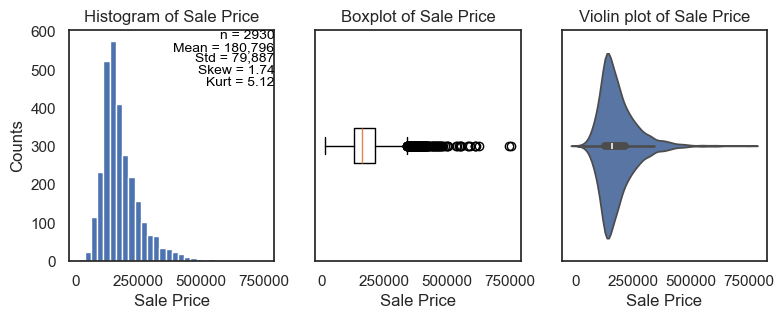

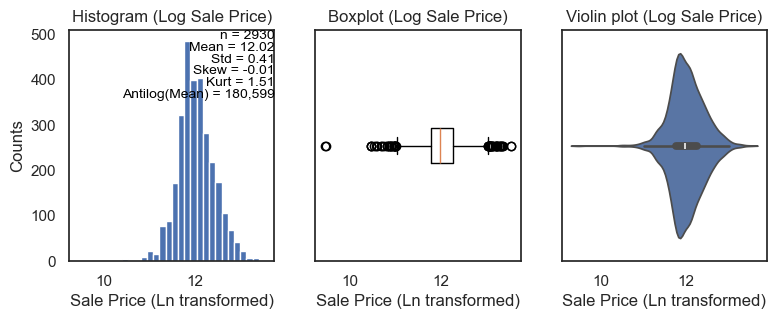

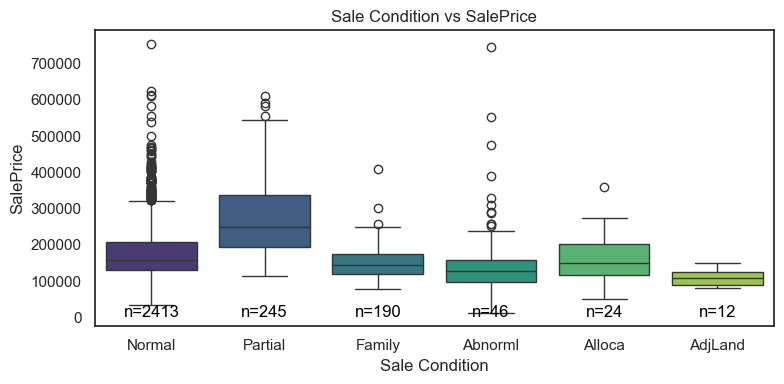

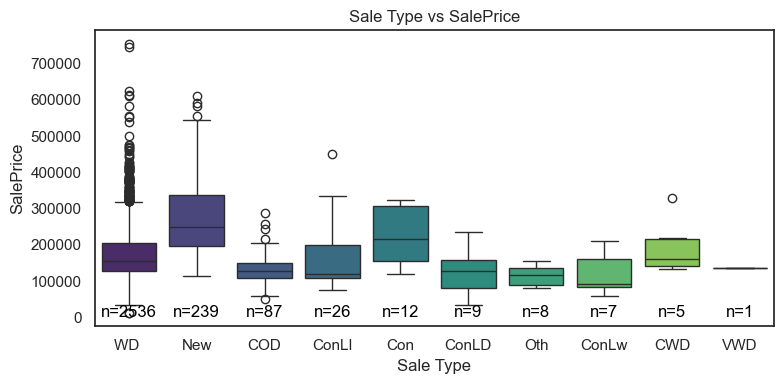

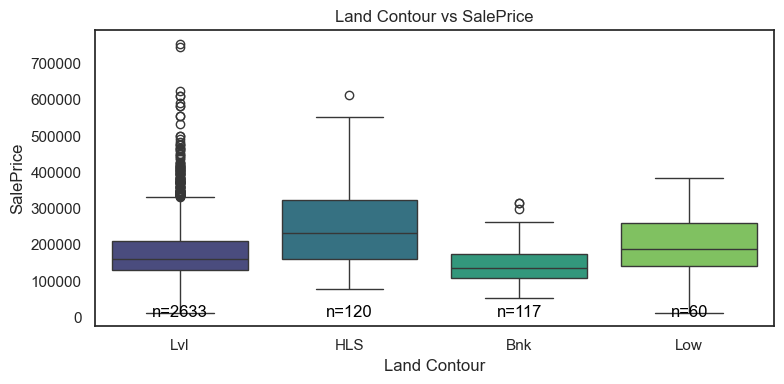

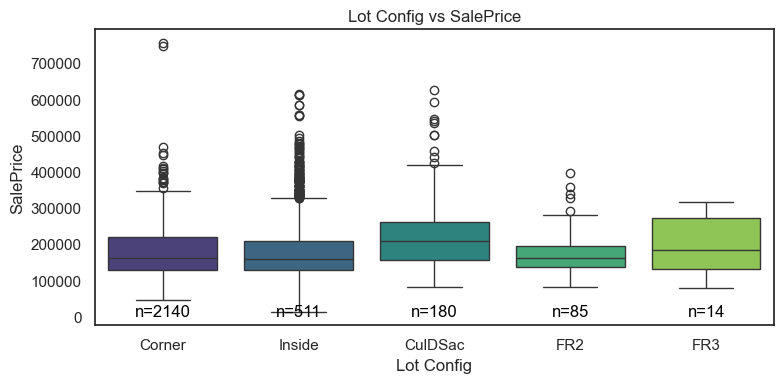

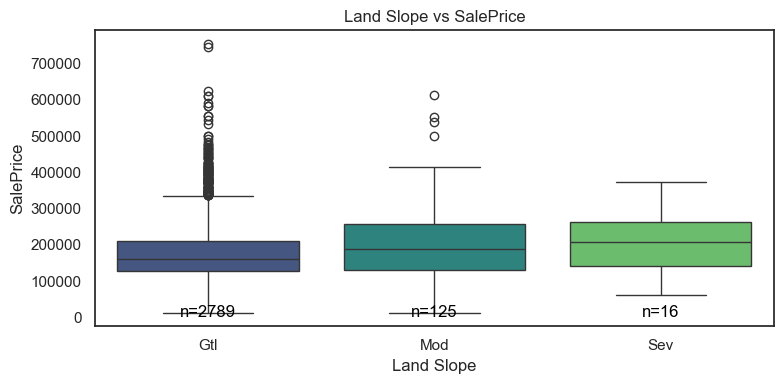

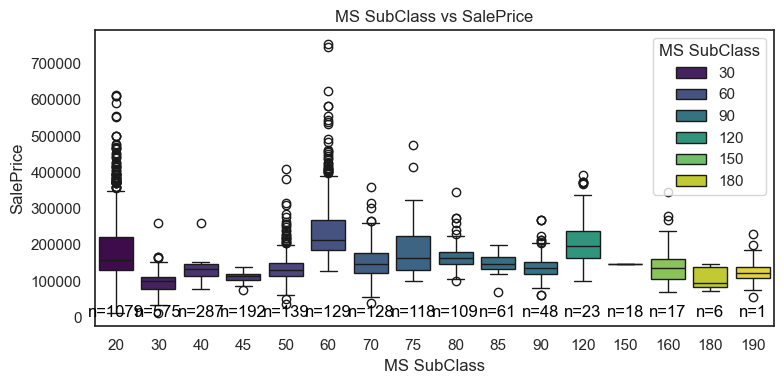

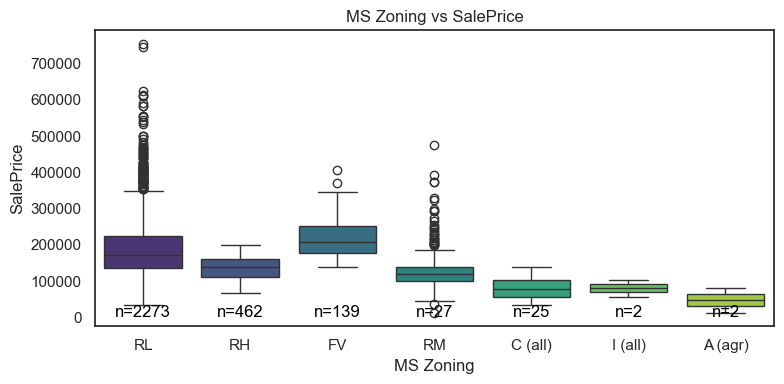

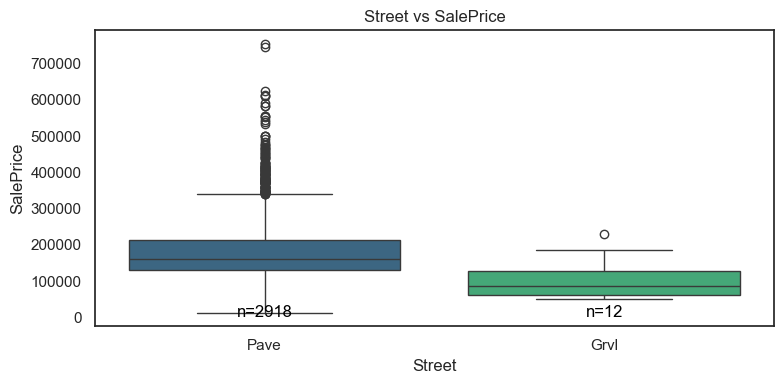

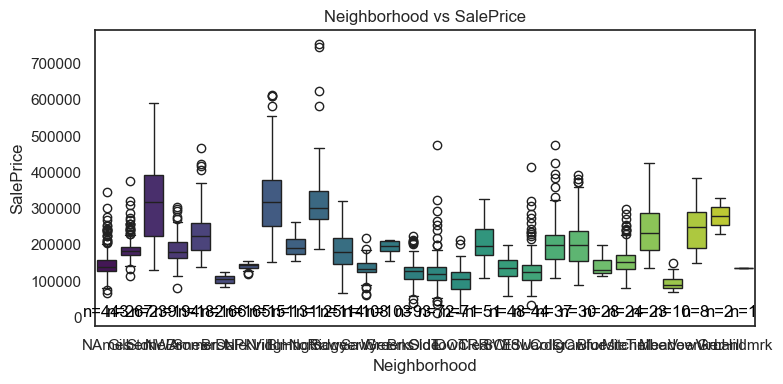

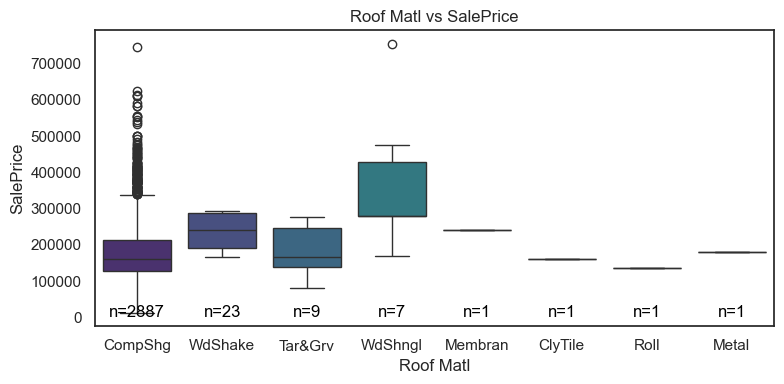

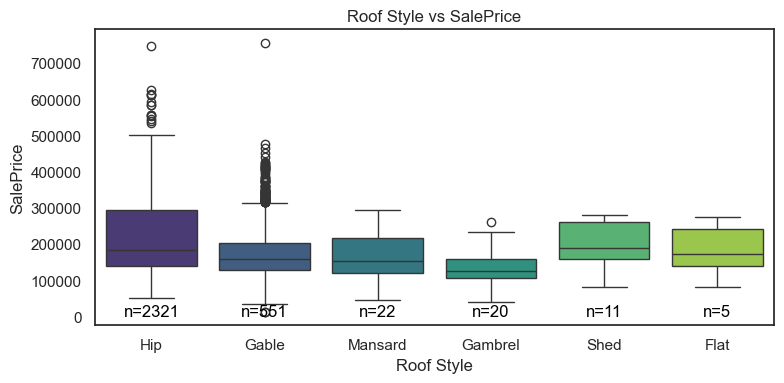

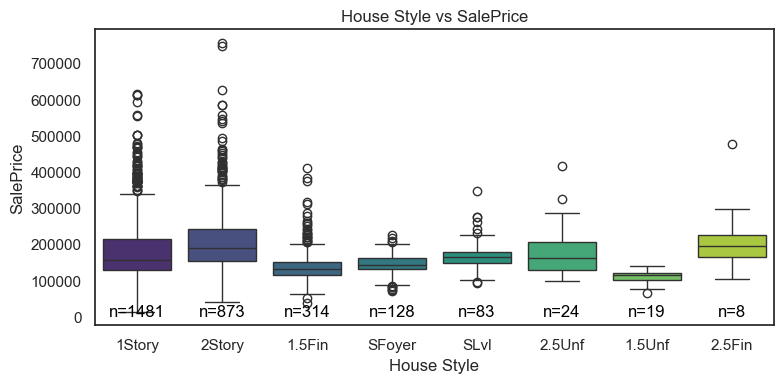

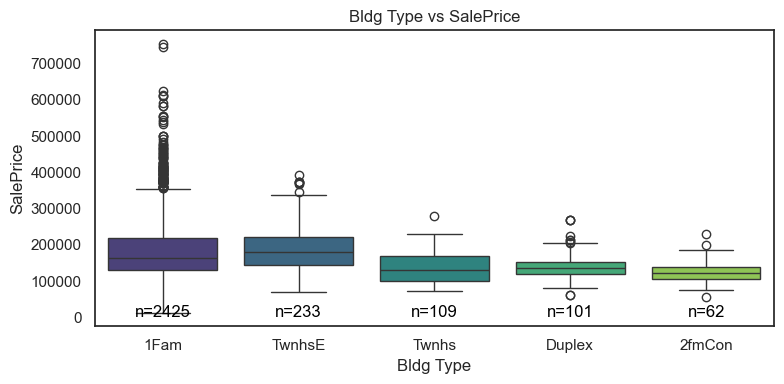

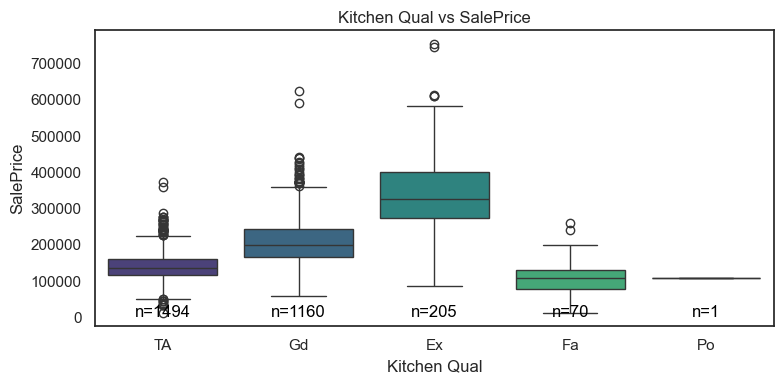

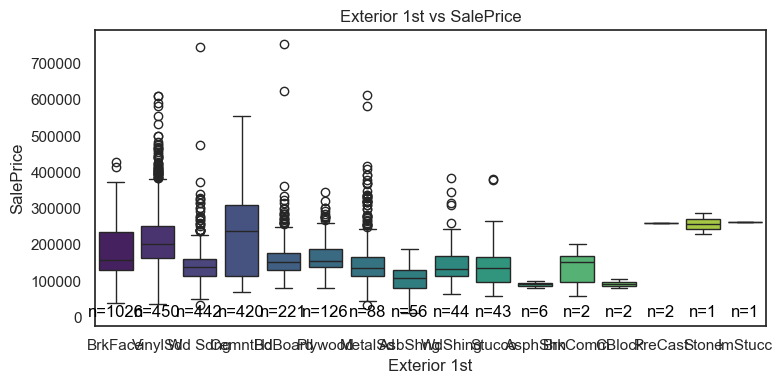

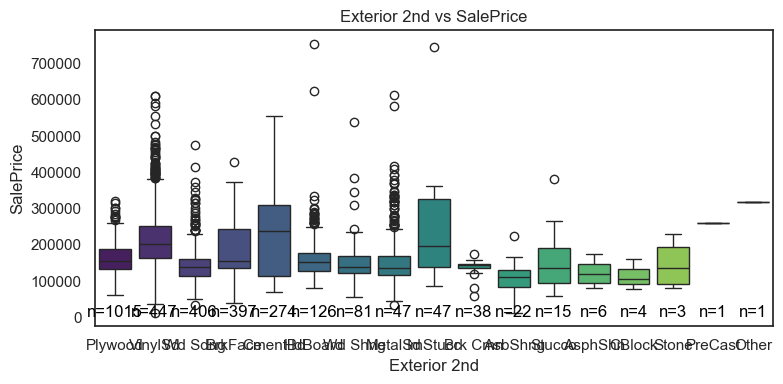

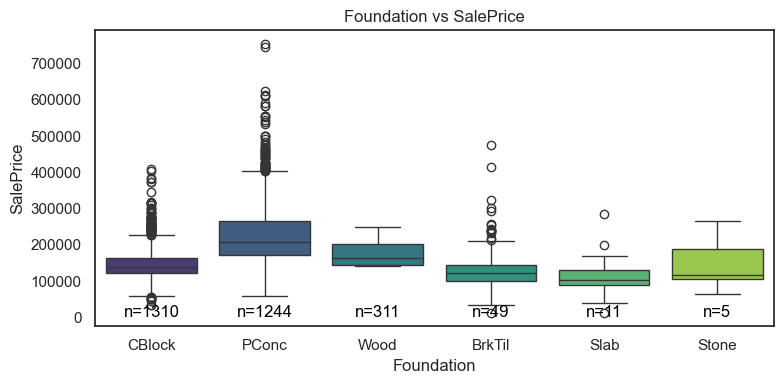

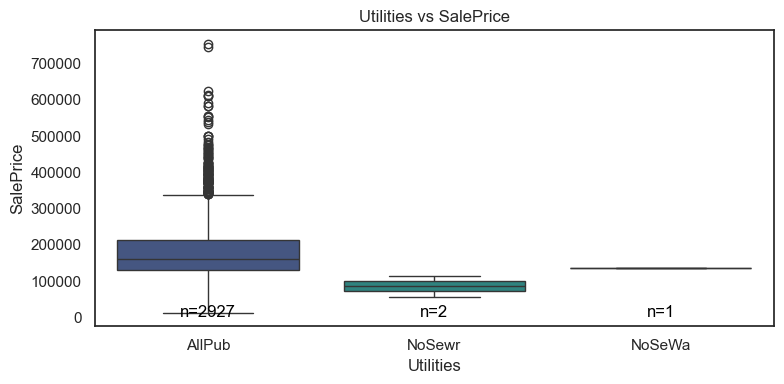

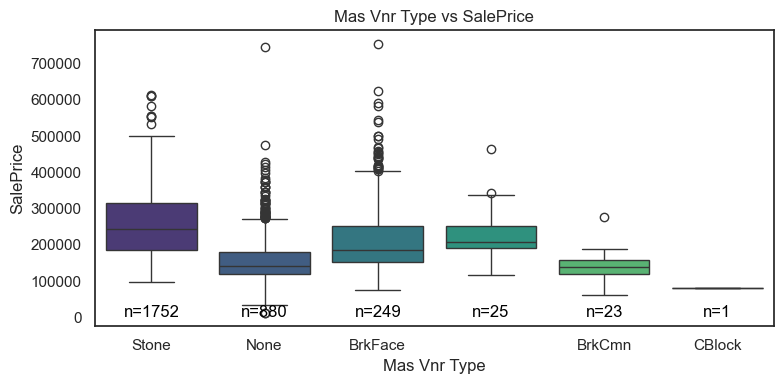

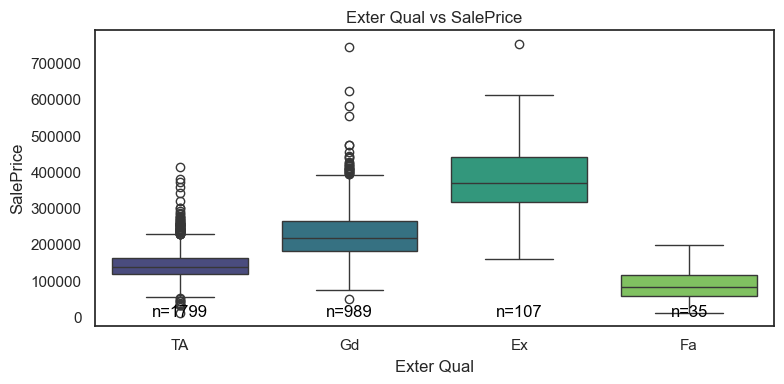

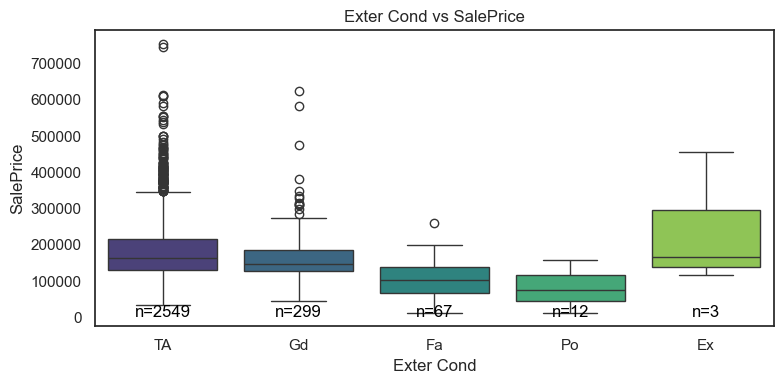

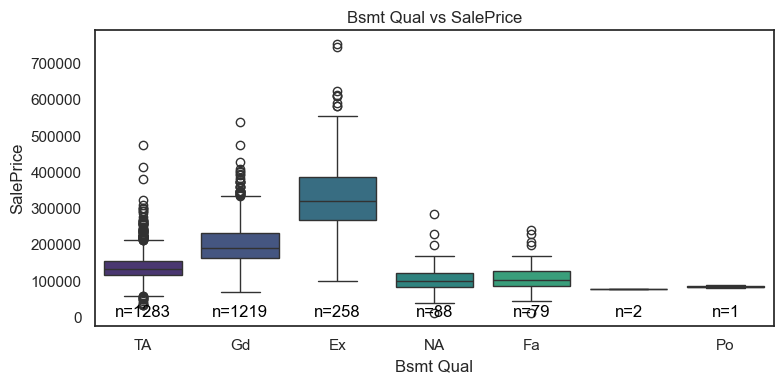

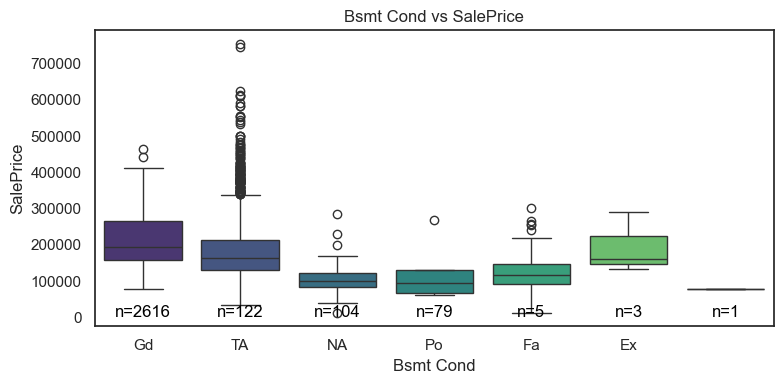

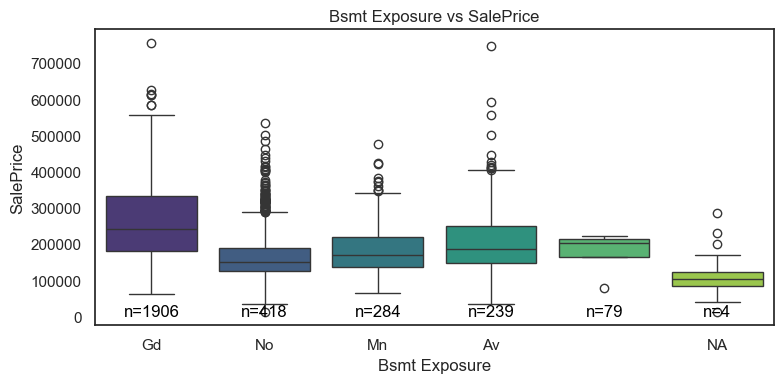

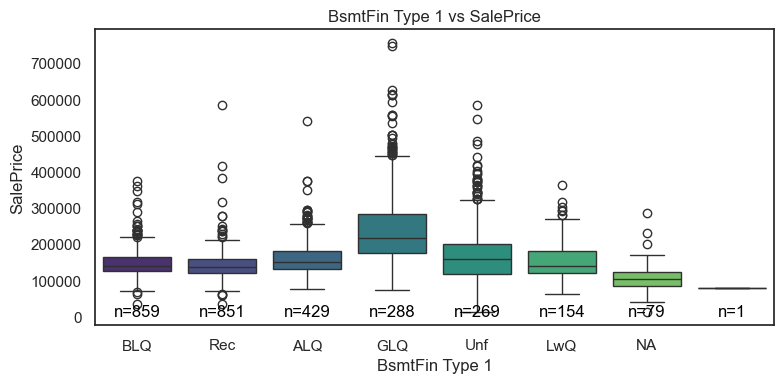

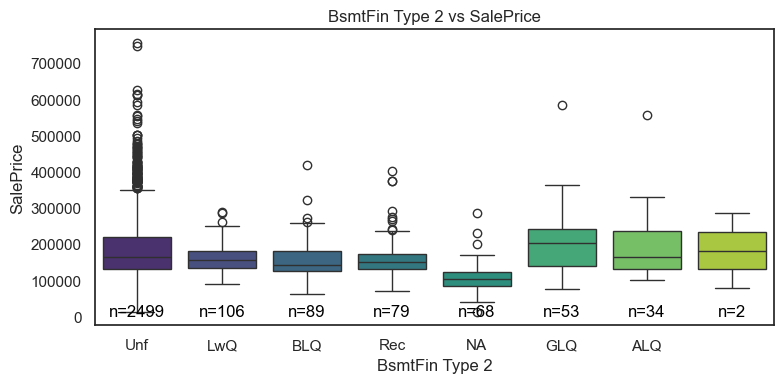

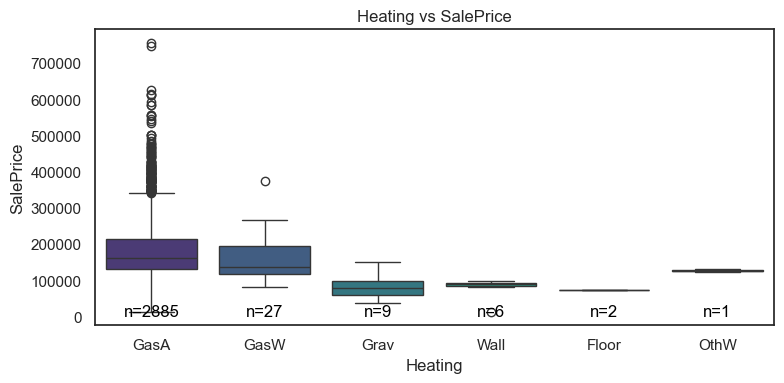

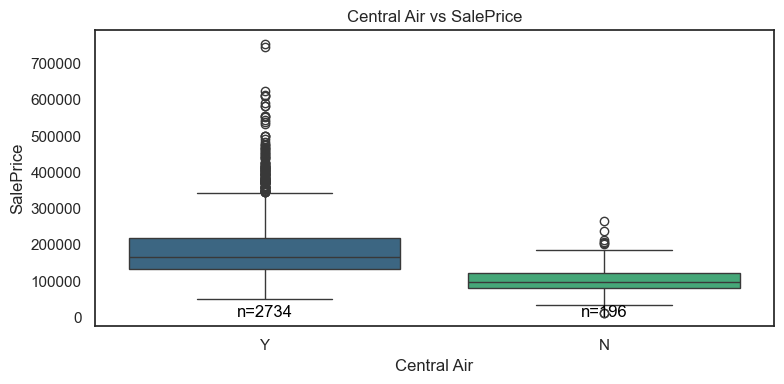

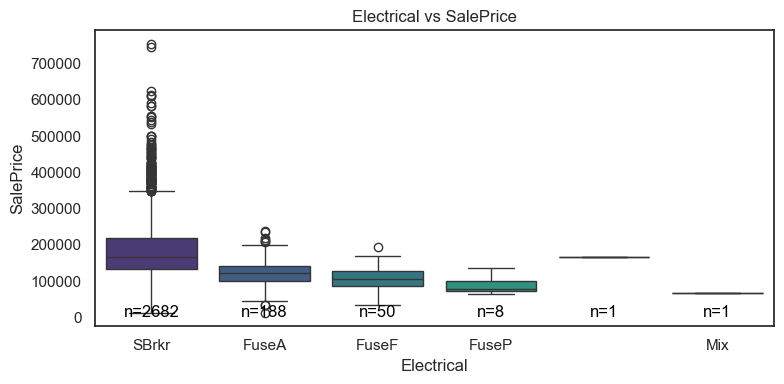

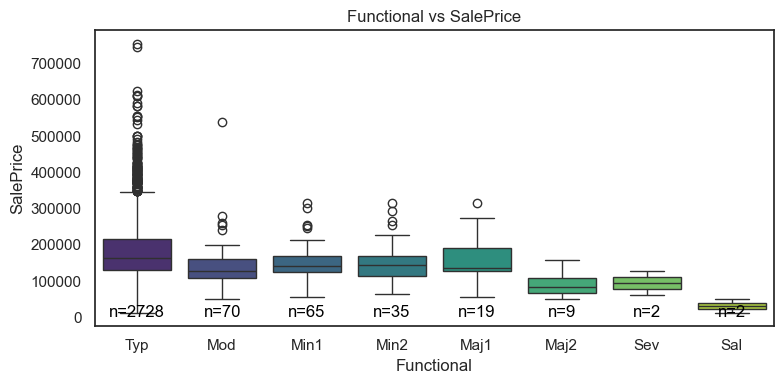

Korrelation nach Pearson


SalePrice                 1.000000
SalesPriceLog             0.957991
Overall Qual              0.806857
Gr Liv Area               0.730879
NeighborhoodClass         0.715478
Exter Qual                0.702894
Kitchen Qual              0.693045
1st Flr SF                0.650531
TotalBathrooms            0.637204
Bsmt Qual                 0.598922
Year Built                0.558236
Full Bath                 0.544010
Garage Finish             0.543210
Garage Yr Blt             0.541782
Year Remod/Add            0.529174
Fireplace Qu              0.528192
Foundation_PConc          0.520372
Mas Vnr Area              0.516035
TotRms AbvGrd             0.514651
Fireplaces                0.477890
Heating QC                0.446316
BsmtFin SF 1              0.440502
Neighborhood_NridgHt      0.439105
Total Bsmt SF             0.418962
Bsmt Exposure             0.399428
TotalPorchSF              0.388123
Sale Type_New             0.367848
Lot Frontage              0.367155
Sale Condition_Parti

Korrelation nach Spearman


SalePrice                 1.000000
SalesPriceLog             1.000000
Overall Qual              0.814384
NeighborhoodClass         0.743136
Gr Liv Area               0.737054
TotalBathrooms            0.711532
Bsmt Qual                 0.696874
Exter Qual                0.689775
Year Built                0.680124
Kitchen Qual              0.675162
Garage Yr Blt             0.649396
Full Bath                 0.637165
Garage Finish             0.612869
1st Flr SF                0.591038
Year Remod/Add            0.590942
Foundation_PConc          0.584941
Fireplace Qu              0.543512
Fireplaces                0.525145
TotRms AbvGrd             0.513992
Heating QC                0.509608
Open Porch SF             0.479675
Mas Vnr Area              0.444308
Garage Type_Attchd        0.442293
Lot Area                  0.441162
TotalPorchSF              0.424935
Lot Frontage              0.411055
Exterior_VinylSd          0.400024
BsmtFin Type 1            0.382529
Wood Deck SF        

Korrelation nach Kendall


SalePrice                 1.000000
SalesPriceLog             1.000000
Overall Qual              0.675955
NeighborhoodClass         0.615710
Bsmt Qual                 0.574978
Exter Qual                0.569688
Kitchen Qual              0.557907
TotalBathrooms            0.556406
Gr Liv Area               0.547974
Full Bath                 0.518936
Year Built                0.490483
Garage Finish             0.483529
Foundation_PConc          0.478266
Garage Yr Blt             0.464546
Fireplace Qu              0.430642
Year Remod/Add            0.426870
1st Flr SF                0.424605
Fireplaces                0.418603
Heating QC                0.399189
TotRms AbvGrd             0.396183
Garage Type_Attchd        0.361633
Open Porch SF             0.350792
Mas Vnr Area              0.341120
Exterior_VinylSd          0.327073
Lot Area                  0.305239
TotalPorchSF              0.293047
BsmtFin Type 1            0.292659
Lot Frontage              0.291112
Garage Qual         

Text(0.5, 0.98, 'Rgression lines for suburbs with more than 150 houses')

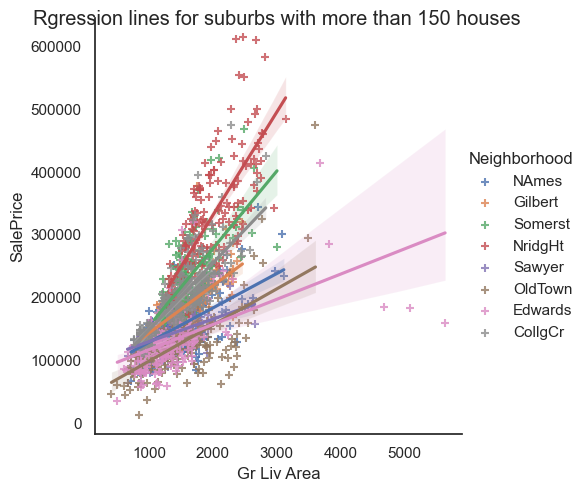

In [26]:
# Statistische Kennwerte für SalePrice



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Hilfsfunktion zum Einfügen der Statistiken (nur im ersten Subplot)
# ------------------------------
def add_stats_text(ax, stats_dict, font_size=10):
    # Sicherstellen, dass Achsengrenzen korrekt berechnet sind
    ax.figure.canvas.draw()

    # Achsengrenzen
    x_max = ax.get_xlim()[1]
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    y_range = y_max - y_min

    # Zeilenabstand (ca. 120% der "Zeichenhöhe")
    line_spacing = y_range * 0.05

    # Texte oben rechts ausgeben
    for i, (label, value) in enumerate(stats_dict.items()):
        ax.text(x_max, y_max - i * line_spacing,
                f"{label} = {value}",
                ha='right', va='top',
                fontsize=font_size, color='black')

# ------------------------------
# Original SalePrice
# ------------------------------
n = df.shape[0]
mean = df['SalePrice'].mean()
std = df['SalePrice'].std()
skew = df['SalePrice'].skew()
kurt = df['SalePrice'].kurt()

stats_saleprice = {
    "n": f"{n}",
    "Mean": f"{mean:,.0f}",
    "Std": f"{std:,.0f}",
    "Skew": f"{skew:.2f}",
    "Kurt": f"{kurt:.2f}"
}

fig = plt.figure(figsize=(9, 3))

# Subplot 1: Histogram mit Statistik-Text
a = fig.add_subplot(1, 3, 1)
_ = a.hist(df['SalePrice'], bins=30)
_ = a.set_title('Histogram of Sale Price')
_ = a.set_xlabel('Sale Price')
_ = a.set_ylabel('Counts')
add_stats_text(a, stats_saleprice)

# Subplot 2: Boxplot ohne Text
a = fig.add_subplot(1, 3, 2)
_ = a.boxplot(df['SalePrice'], vert=False)
_ = a.set_title('Boxplot of Sale Price')
_ = a.set_xlabel('Sale Price')
_ = a.set_yticklabels([])

# Subplot 3: Violinplot ohne Text
a = fig.add_subplot(1, 3, 3)
_ = sns.violinplot(x=df['SalePrice'], ax=a)
_ = a.set_title('Violin plot of Sale Price')
_ = a.set_xlabel('Sale Price')

# ------------------------------
# Log-transformed SalePrice
# ------------------------------
log_prices = np.log(df['SalePrice'])
mean_log = log_prices.mean()
std_log = log_prices.std()
skew_log = log_prices.skew()
kurt_log = log_prices.kurt()

# Korrekt berechneter Antilog (erwarteter Mittelwert bei lognormaler Verteilung)
antilog_mean_log = np.exp(mean_log + (std_log**2) / 2)
"""
Rücktransformierte Mittel ist ca 200 $ kleiner, also robuster.
Der arithmetische Mittelwert ist sehr empfindlich gegenüber Ausreißern (teure Häuser).
Der zurückgerechnete Mittelwert aus der Log-Verteilung ist ein robusterer Schätzer, weil er auf der Annahme basiert, dass die Daten lognormalverteilt sind – was in der Praxis oft zutrifft für Preise, Einkommen. 
Sie spiegelt die asymmetrische Natur der Daten und die Wirkung der logarithmischen Transformation wider.
Beide Werte (originaler Mittelwert und antilogarithmisch rekonstruierter) sind nützlich – für verschiedene Zwecke.
"""

stats_log = {
    "n": f"{len(log_prices)}",
    "Mean": f"{mean_log:.2f}",
    "Std": f"{std_log:.2f}",
    "Skew": f"{skew_log:.2f}",
    "Kurt": f"{kurt_log:.2f}",
    "Antilog(Mean)": f"{antilog_mean_log:,.0f}"
}

fig = plt.figure(figsize=(9, 3))

# Subplot 1: Histogram mit Statistik-Text
a = fig.add_subplot(1, 3, 1)
_ = a.hist(log_prices, bins=30)
_ = a.set_title('Histogram (Log Sale Price)')
_ = a.set_xlabel('Sale Price (Ln transformed)')
_ = a.set_ylabel('Counts')
add_stats_text(a, stats_log)

# Subplot 2: Boxplot ohne Text
a = fig.add_subplot(1, 3, 2)
_ = a.boxplot(log_prices, vert=False)
_ = a.set_title('Boxplot (Log Sale Price)')
_ = a.set_xlabel('Sale Price (Ln transformed)')
_ = a.set_yticklabels([])

# Subplot 3: Violinplot ohne Text
a = fig.add_subplot(1, 3, 3)
_ = sns.violinplot(x=log_prices, ax=a)
_ = a.set_title('Violin plot (Log Sale Price)')
_ = a.set_xlabel('Sale Price (Ln transformed)')

# ------------------------------
# Boxplots für kategoriale Variablen (unverändert)
# ------------------------------
def my_boxplot(df, columnname):
    _ = plt.figure(figsize=(8, 4))
    ax = sns.boxplot(x=columnname, y='SalePrice', data=df, hue=columnname, palette='viridis')
    _ = plt.title(columnname + ' vs SalePrice')
    _ = plt.tight_layout()

    # Gruppengrößen einfügen
    nobs = df[columnname].value_counts().values
    nobs = [f"n={x}" for x in nobs.tolist()]
    for tick, label in zip(range(len(nobs)), ax.get_xticklabels()):
        _ = ax.text(tick, 1000, nobs[tick], ha='center', color='black')
    plt.show()

# Liste der kategorialen Variablen
for i in ['Sale Condition', 'Sale Type',
          'Land Contour', 'Lot Config', 'Land Slope', 'MS SubClass', 'MS Zoning', 'Street', 
          'Neighborhood', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type',
          'Kitchen Qual', 'Exterior 1st', 'Exterior 2nd', 'Foundation',
          'Utilities', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
          'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 
          'Heating', 'Central Air', 'Electrical', 'Functional']:
    my_boxplot(df, i)

# Ist ein lineares Modell angebracht? Zeigen Merkmale eine proportionale Steigerung in Bezug auf den Verkaufspreis?
#
# Liste der Pearson Korrelationskoeffzienten aller Variablen mit SalePrice (statt Heatmap)
# nach https://medium.com/@hjhuney/quantitative-data-exploration-for-regression-in-python-ames-housing-part-1-25879dd4cc4a
#PearsonCorr_list = df_num.corr(method='pearson', numeric_only=False).to_dict()['SalePrice'].items(), key=lambda x: x[1], reverse=True)
print ("Korrelation nach Pearson")
df_num[df_num.columns].corr(method='pearson', numeric_only=True)['SalePrice'].sort_values(ascending=False)
print ("Korrelation nach Spearman")
df_num[df_num.columns].corr(method='spearman', numeric_only=True)['SalePrice'].sort_values(ascending=False)
print ("Korrelation nach Kendall")
df_num[df_num.columns].corr(method='kendall', numeric_only=True)['SalePrice'].sort_values(ascending=False)

df_neighbor = df[['SalePrice', "Gr Liv Area", "Neighborhood"]]
counts = df_neighbor['Neighborhood'].value_counts()
res = df_neighbor[~df_neighbor['Neighborhood'].isin(counts[counts < 150].index)]
#print(res)
splot = sns.lmplot(x="Gr Liv Area", 
               y="SalePrice", 
               hue="Neighborhood", 
               markers='+', 
               data=res) 
splot.fig.suptitle('Rgression lines for suburbs with more than 150 houses')



# Gibt es einen Absschlag für grosse Wohnflächen? > 80% Quantil je Vorort?
# Ist Gross Living Area ein proxy für den Verkaufspreis?
# Powerlaws? price vs feature, price vs feature^power, and price vs boxcox(feature)


<Axes: >

Text(0.5, 0, 'House price in USD/sqft Lot_Area')

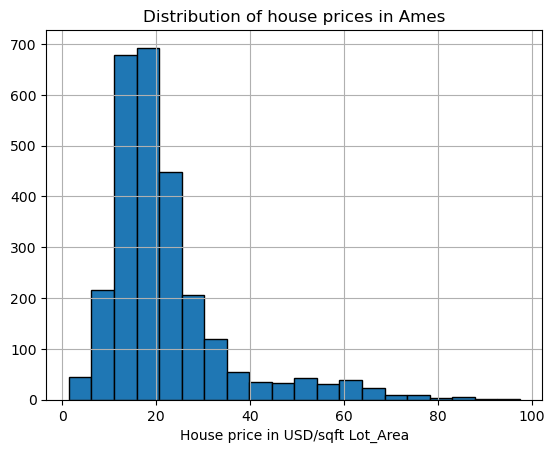

In [7]:
# Wie verhält sich der SalePrice pro square foot?
SalePriceSQT = df_num['SalePrice'] / df_num['Lot Area'] 
SalePriceSQT.hist(bins=20, edgecolor="black")
plt.xlabel("House price in USD/sqft Lot_Area")
_ = plt.title("Distribution of house prices in Ames")

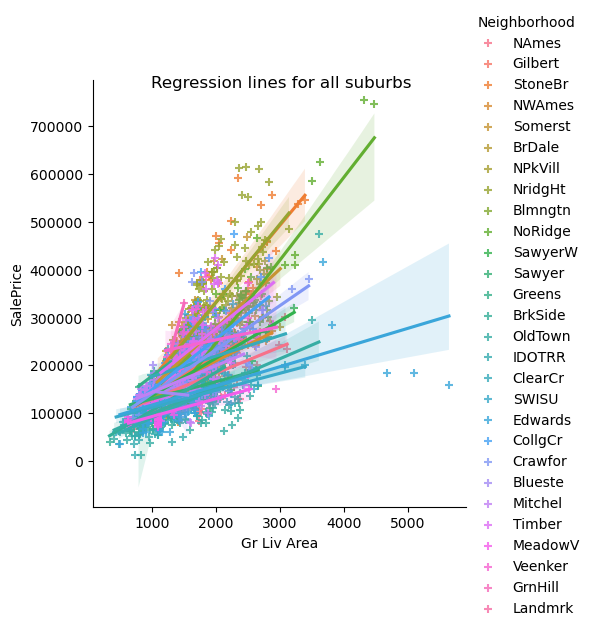

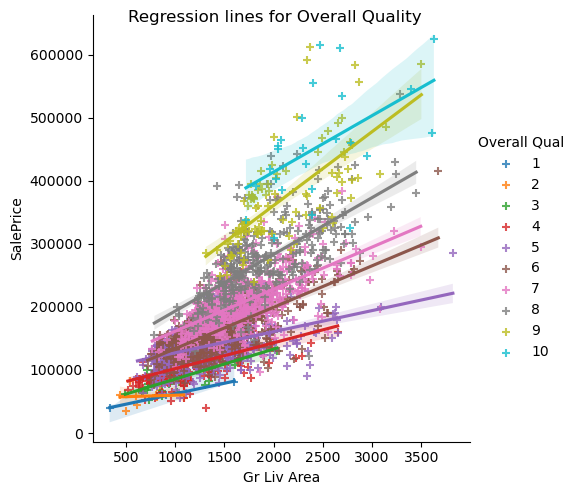

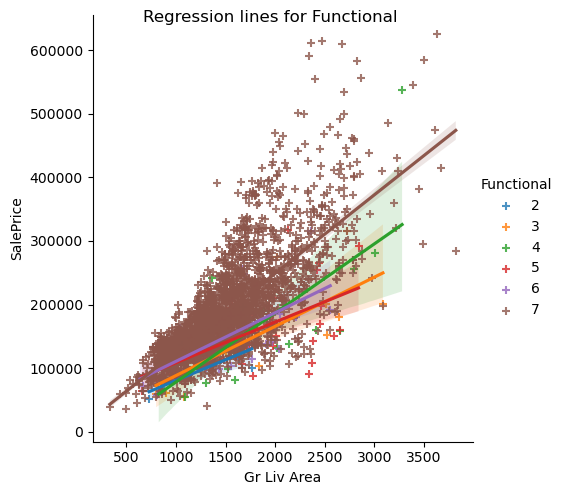

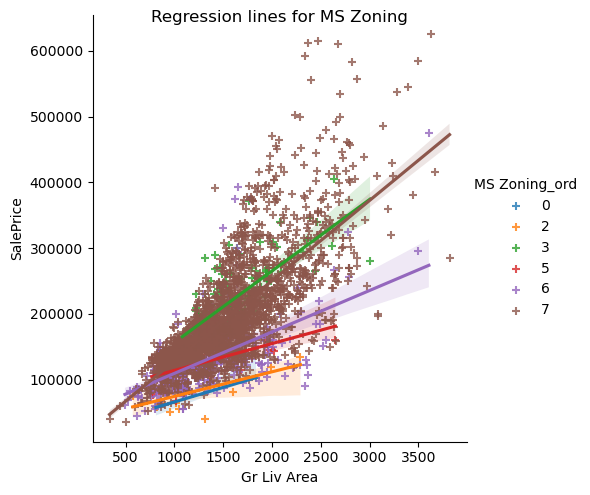

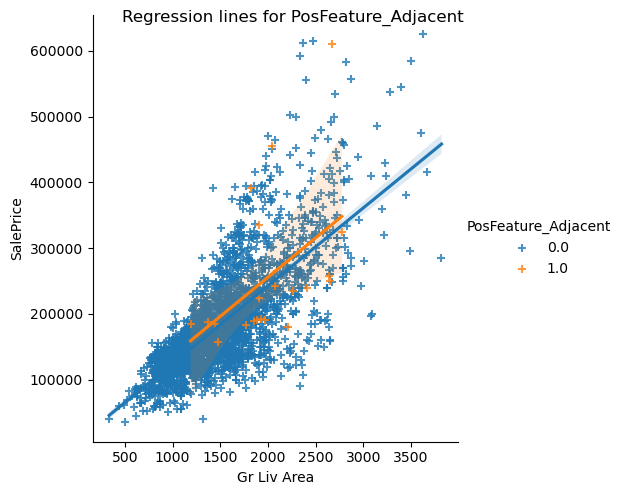

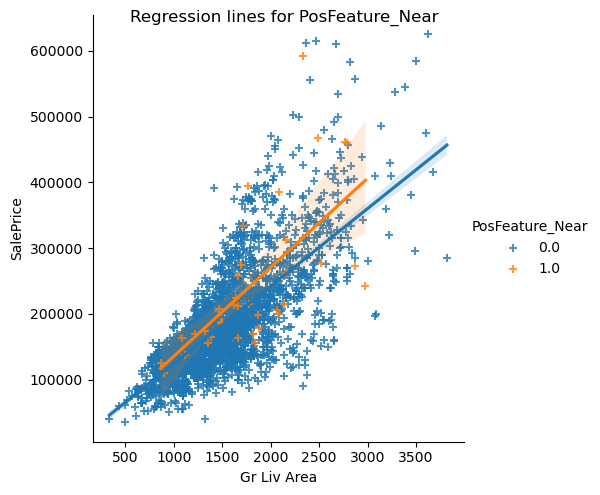

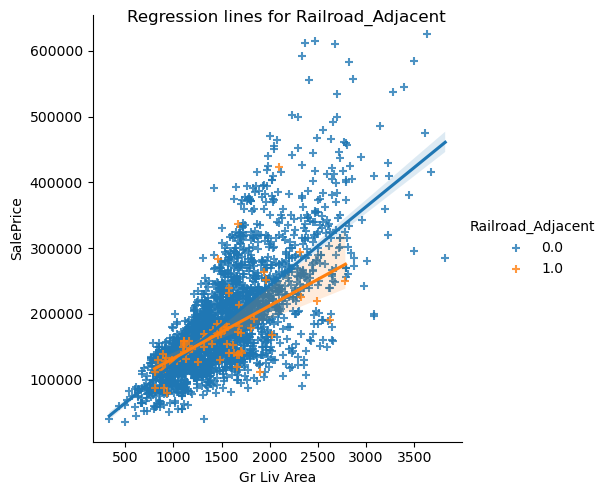

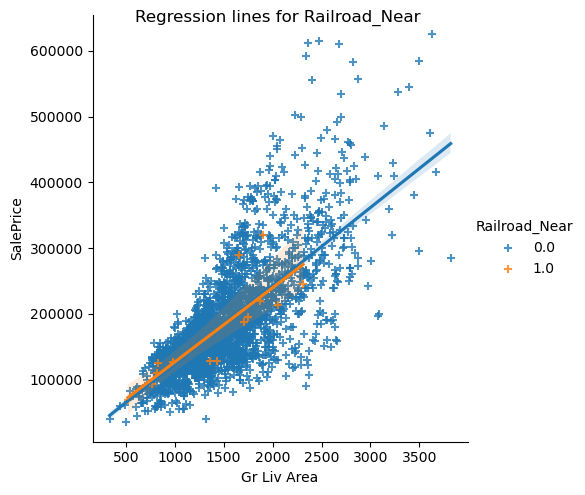

In [8]:
# Lineare TeilModelle für gruppierte Daten 

def plot_lm (x,y,groups, data, title):
    ''' Lineare Modelle für gruppierte Daten plotten
    '''
    splot = sns.lmplot(x=x, 
                   y=y, 
                   hue=groups, 
                   markers='+', 
                   data=data) 
    splot.fig.suptitle(title)


df_neighbor = df[['SalePrice', "Gr Liv Area", "Neighborhood"]]
counts = df_neighbor['Neighborhood'].value_counts()
# res = df_neighbor[~df_neighbor['Neighborhood'].isin(counts[counts < 150].index)] # für Vororte mit > 150 Verkäufen
res = df_neighbor
#print(res) # res als Zwischenspeicher für Vororte mit > 150 verkauften Häusern
plot_lm ("Gr Liv Area","SalePrice","Neighborhood", res , 'Regression lines for all suburbs')  #with more than 150 houses
plot_lm ("Gr Liv Area","SalePrice","Overall Qual", df_num , 'Regression lines for Overall Quality')
plot_lm ("Gr Liv Area","SalePrice","Functional", df_num , 'Regression lines for Functional')
plot_lm ("Gr Liv Area","SalePrice","MS Zoning_ord", df_num , 'Regression lines for MS Zoning') # ordinal scaled
plot_lm ("Gr Liv Area","SalePrice","PosFeature_Adjacent", df_num , 'Regression lines for PosFeature_Adjacent')
plot_lm ("Gr Liv Area","SalePrice","PosFeature_Near", df_num , 'Regression lines for PosFeature_Near')
plot_lm ("Gr Liv Area","SalePrice","Railroad_Adjacent", df_num , 'Regression lines for Railroad_Adjacent')
plot_lm ("Gr Liv Area","SalePrice","Railroad_Near", df_num , 'Regression lines for Railroad_Near')


In [9]:
# Abfrage von Häuser nach mehreren Kriterien
# Gibt es Widersprüche?

cond1 = (df["Lot Area"] >= 12000)
cond2 = (df["Lot Area"] <= 14000)
cond3 = (df["Gr Liv Area"] >= 200)
cond4 = (df["Gr Liv Area"] >= 1500)
cond5 = (df["Gr Liv Area"] <= 2200)
cond6 = (df["Gr Liv Area"] >= 500)
cond7 = (df["Overall Qual"] >= 7)
cond8 = (df["Year Built"] >= 2000)
cond9 = (df["Year Built"] >= 2000)
len(np.where(cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9)[0])

#np.where(cond1 & cond2)         
df.loc[cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9].sort_values(by=['SalePrice'])


57

Order        PID  MS SubClass MS Zoning Lot Frontage  Lot Area Street  \
1133   1134  531373060           60        RL           67     12774   Pave   
2806   2807  907401080           60        RL           41     12393   Pave   
2778   2779  907192010           60        RL           95     13450   Pave   
2780   2781  907196020           20        RL          118     13704   Pave   
1578   1579  916386180           60        RL           81     12018   Pave   
40       41  528120100           20        RL           95     12182   Pave   
958     959  916382010           60        RL           83     13159   Pave   
1615   1616  527105140           60        RL                  12394   Pave   
848     849  907194010           60        RL           79     12420   Pave   
1441   1442  907194020           60        RL           80     12435   Pave   
1442   1443  907196040           60        RL           75     12192   Pave   
947     948  914465040           50        RL           48     12822   Pave   
948     949  914465055           20        RL           43     12118   Pave   
1113   1114  528429070           20        RL           74     13253   Pave   
520     521  528458140           20        FV          112     12606   Pave   
2318   2319  527108030           60        RL           50     13128   Pave   
2454   2455  528429060           60        RL           75     12447   Pave   
426     427  528108020           20        RL           98     12704   Pave   
863     864  907252060           60        RL                  12334   Pave   
70       71  528477080           60        FV          100     12552   Pave   
1781   1782  528431050           20        RL          116     13501   Pave   
484     485  528275160           60        RL                  12891   Pave   
1575   1576  916384100           60        RL          107     12852   Pave   
318     319  916386090           60        RL           92     12003   Pave   
445     446  528142150           20        RL           90     12878   Pave   
1564   1565  914465060           20        RL                  13265   Pave   
1072   1073  528186030          120        RL           62     12677   Pave   
2402   2403  528172150           60        RL                  13215   Pave   
871     872  907275140           20        RL                  12782   Pave   
1711   1712  528172030           60        RL                  12568   Pave   
39       40  528120090           20        RL           94     12883   Pave   
2383   2384  528112010           20        RL          108     12228   Pave   
1799   1800  528458150           60        FV          112     12217   Pave   
957     958  916380070           20        RL           89     12898   Pave   
1054   1055  528108150           20        RL           98     12704   Pave   
1688   1689  528102130           20        RL           93     12085   Pave   
1686   1687  528102100           20        RL           93     12030   Pave   
891     892  908154040           20        RL           86     13286   Pave   
2900   2901  916477010           20        RL           95     13618   Pave   
441     442  528138010           20        RL          102     13514   Pave   
424     425  528106070           20        RL          108     13173   Pave   
420     421  528102040           20        RL           96     12456   Pave   
1684   1685  528102050           20        RL           96     12469   Pave   
2395   2396  528142110           20        RL           90     12378   Pave   
1706   1707  528150040           20        RL           94     13615   Pave   
2397   2398  528150080           20        RL          121     13758   Pave   
1055   1056  528110080           20        RL          107     13891   Pave   
321     322  921128020           20        RL           89     13214   Pave   
2275   2276  921128030           20        RL           85     12633   Pave   
1050   1051  528102030           20        RL           

In [10]:
# Zelle für temporäre Untersuchungen

#df.loc[df['Sale Condition'] == 'Abnorml']
#df_num.loc[df['Order'] ==2928]
#df_num[(df_num['Garage Yr Blt'].isnull())] 
#df_num['Garage Yr Blt'].fillna(0)
#df_num['Garage Yr Blt'].value_counts()
#df_num['Garage Yr Blt'].astype(int)
#sorted(df['Neighborhood'].unique())
#df.groupby(by=['Neighborhood'])['SalePrice'].mean()


#df.groupby(by=['Neighborhood'])['SalePrice'].mean().describe()

#_ = plt.hist(df['SalePrice'],bins=80)


#df.groupby(['Neighborhood'])['SalePrice'].agg([('Count','count'), 
#       ('Sum','sum'), 
#       ('Min', lambda x: x.quantile(0)),
#       ('Q1', lambda x: x.quantile(0.25)),
#       ('Q2', lambda x: x.quantile(0.5)),
#       ('Q3', lambda x: x.quantile(0.75)),
#       ('Max', lambda x: x.quantile(1))]).sort_values(by='Q2', ascending=True)

#print (df_num['Neighborhood_org'].eq("").sum())

#with pd.option_context('display.max_rows', 3000,
#                       'display.max_columns', 8,
#                       'display.precision', 3,
#                       'display.width',-1,
#                       'expand_frame_repr', True
#                       ):
#    print(df_num['Neighborhood_org'])

print(df_num['Neighborhood_org'].str.cat(sep=", ")) # print column / series in one line

# display(df_num[['Garage Finish','Garage Area']].loc[df_num['Garage Finish'].isnull()])


NAmes, NAmes, NAmes, NAmes, Gilbert, Gilbert, StoneBr, StoneBr, StoneBr, Gilbert, Gilbert, Gilbert, Gilbert, Gilbert, StoneBr, StoneBr, Gilbert, StoneBr, Gilbert, NWAmes, NWAmes, Somerst, NAmes, NAmes, NAmes, NAmes, NAmes, NAmes, BrDale, BrDale, NPkVill, NPkVill, NPkVill, NPkVill, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, NridgHt, Gilbert, Blmngtn, Blmngtn, Gilbert, Gilbert, Gilbert, Gilbert, Gilbert, NoRidge, NoRidge, NoRidge, NoRidge, NoRidge, NoRidge, NoRidge, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, SawyerW, Sawyer, Sawyer, Sawyer, Sawyer, Sawyer, Sawyer, NoRidge, NoRidge, NoRidge, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Somerst, Greens, Greens, Sawyer, Somerst, NWAmes, NWAmes, NWAmes, NWAmes, NWAmes, NWAmes, NWAmes, NAmes, NWAmes,

In [11]:
# Missing Values, Datenqualitätsdimension Vollständigkeit, Fehlende Werte

#df_num.info(verbose=True, show_counts=True )
#df_org.info(verbose=True)


null_stats = pd.DataFrame(df_num.isnull().sum(), columns=['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count'] / df_num.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count', ascending=False)


Empty DataFrame
Columns: [missing_value_count, % of dataset]
Index: []

In [12]:
# Datenqualitätsdimension Fehlerfreiheit und Widersprüche der Daten prüfen
# Ausgabemenge soll auch hier wieder iterativ bisy Null errecht werden, wenn notwendig.

# Do null values for pool_qc indicate a lack of a pool? no rows should have pool_area > 0 when pool_qc is not None.
df_num[(df_num['Pool Area'] > 0) & (df_num['Pool QC'] == 0)]['SalePrice'].count()
# Likewise for fireplace_qu and fireplaces
df_num[(df_num['Fireplaces'] > 0) & (df_num['Fireplace Qu'] == 0)]['SalePrice'].count()
# And also misc_val and misc_feature (one hot encoded in df_num)
df[(df['Misc Val'] > 0) & (df['Misc Feature'] == "NA")]['SalePrice'].count()

# Verkauft bevor gebaut oder remodeled?
df_num.loc[df_num['Yr Sold']+1 < df_num['Year Built'] ]['Order'].count() # 1 Jahr vor Ende Bau schon verkauft, ist korrekt.
df_num.loc[df_num['Year Built'] > df_num['Year Remod/Add']+1]['Order'].count()
df_num.loc[df_num['Yr Sold'] < df_num['Garage Yr Blt']]['Order'].count()
# Falls ein count() > 0, dann entfernen Sie biite das .count() der Zeile, damit die ZeilenNr 
#   und die OrderNo (als Spalte 2!) ausgegeben wird. Dann bitte Fehler ansehen mit der OrderNo
#   und fügen Sie .count() wieder ans Ende des Befehls.
df_num.loc[df_num['Yr Sold'] < df_num['Garage Yr Blt']]['Order']
#print(df_num['Garage Yr Blt'].loc[df['Order'] ==2261])  # Datenfehler, da zuvor 2207
df_num.loc[df_num['Order'] ==2261, 'Garage Yr Blt'] = 2007 # Datenfehler, da zuvor 2207


np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(1)

2260    2261
Name: Order, dtype: int64

In [13]:
# ad hoc Variablenauswertung und -prüfung
df_num[ (df_num['Exter Qual'].isnull())]

#df_num.groupby('Exterior_Plywood').agg(Mittlerer_Preis=('SalePrice', 'mean'), Min_Preis=('SalePrice', 'min'), 
#                            Max_Preis=('SalePrice', 'max'), Mittlere_Grundstücksgröße=('Lot Area', 'mean'), 
#                            Min_Grundstücksgröße=('Lot Area', 'min'), Max_Grundstücksgröße=('Lot Area', 'max'), 
#                             Anzahl=('Order', 'count'))
df_num.groupby('Exter Qual').agg(Mittlerer_Preis=('SalePrice', 'mean'), Min_Preis=('SalePrice', 'min'), 
                            Max_Preis=('SalePrice', 'max'), Mittlere_Grundstücksgröße=('Lot Area', 'mean'), 
                            Min_Grundstücksgröße=('Lot Area', 'min'), Max_Grundstücksgröße=('Lot Area', 'max'), 
                             Anzahl=('Order', 'count'))
# ToDo SalePrice.median wird von Zillow verwendet, ist besser?

Empty DataFrame
Columns: [Order, MS SubClass, MS Zoning, Lot Frontage, Lot Area, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Condition 1, Condition 2, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Exterior 1st, Exterior 2nd, Mas Vnr Area, Exter Qual, Exter Cond, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Val, Mo Sold, Yr Sold, SalePrice, SalesPriceLog, Railroad_Adjacent, Railroad_Near, Street_Feeder, Street_Aterial, PosFeature_Adjacent, PosFeature_Near, NeighborhoodClass, MS Zoning_org, MS Zoning_ord, Alley_org, Street_org, Neighborhood_org, Street_Grvl, Street_Pave, Neighborhood_Blmngtn, Neighborhood_Blueste, Neighborhood_BrDale, Neighborhood_BrkSide, Neighborhood_ClearCr, Neighborhood_CollgCr, Neighborhood_Crawfor, Neighborhood_Edwards, Neighborhood_Gilbert, Neighborhood_Greens, Neighborhood_GrnHill, Neighborhood_IDOTRR, Neighborhood_Landmrk, Neighborhood_MeadowV, Neighborhood_Mitchel, Neighborhood_NAmes, Neighborhood_NPkVill, ...]
Index: []

Mittlerer_Preis  Min_Preis  Max_Preis  Mittlere_Grundstücksgröße  \
Exter Qual                                                                     
-1             88456.241379      39300     163000                8664.241379   
 0            145678.563275      35000     415000                9990.418114   
 1            230758.527983      52000     625000               10082.902851   
 4            378447.960784     176500     615000               12716.519608   

            Min_Grundstücksgröße  Max_Grundstücksgröße  Anzahl  
Exter Qual                                                      
-1                          4761                 21780      29  
 0                          1300                215245    1612  
 1                          1700                159000     947  
 4                          3843                 53504     102

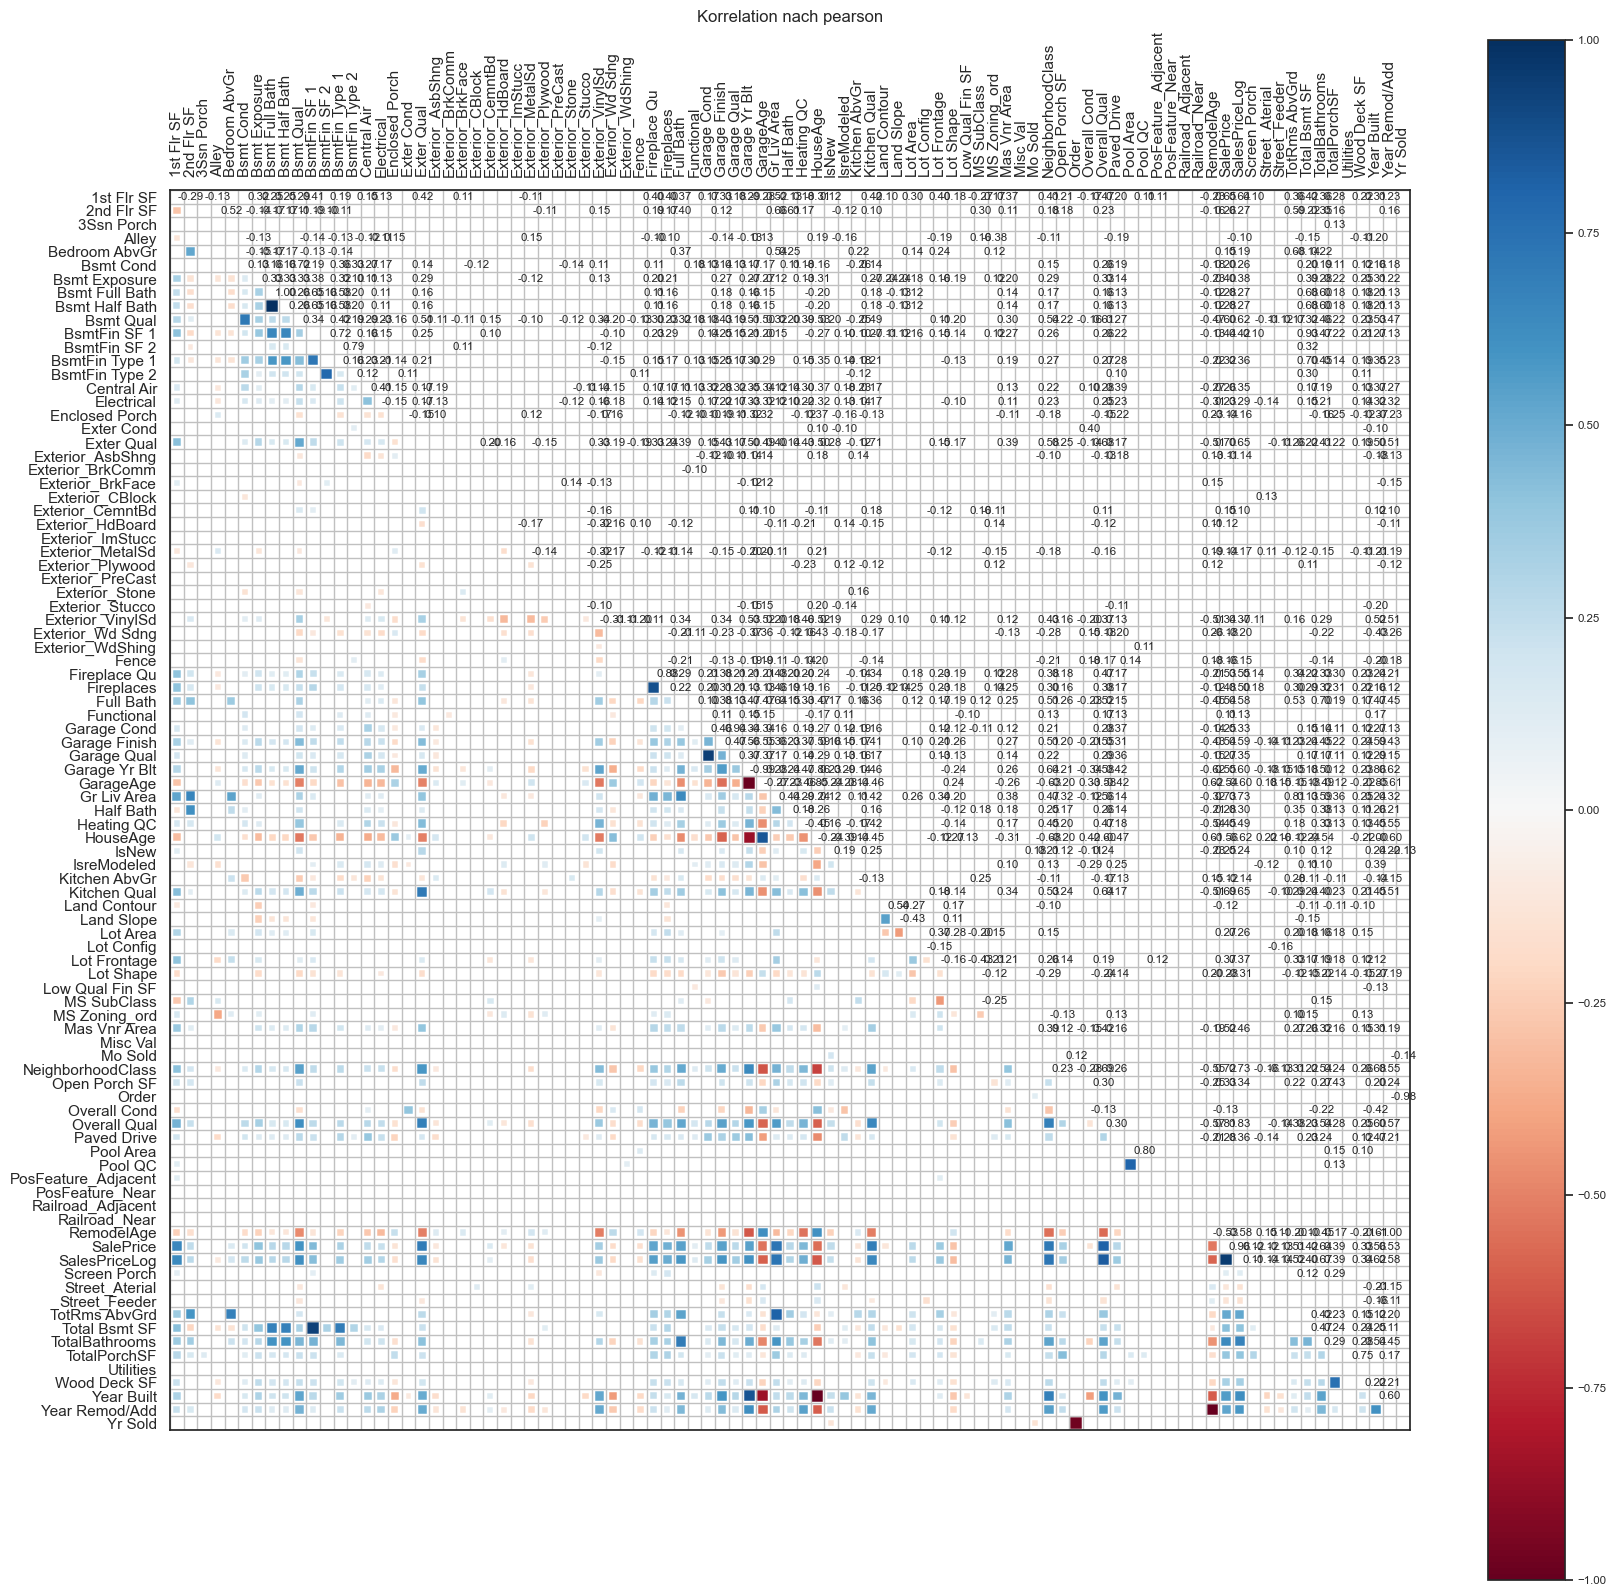

Street_Grvl             Street_Pave              -1.000000
Year Built              HouseAge                 -0.999054
Year Remod/Add          RemodelAge               -0.997970
GarageAge               Garage Yr Blt            -0.988279
Yr Sold                 Order                    -0.975634
Misc Feature_Shed       Misc Feature_NA          -0.951326
Roof Style_Hip          Roof Style_Gable         -0.943460
Garage Type_NA          Garage Cond              -0.937642
Garage Qual             Garage Type_NA           -0.927619
Sale Condition_Partial  Sale Condition_Normal    -0.926122
Sale Type_New           Sale Condition_Normal    -0.913450
HouseAge                Garage Yr Blt            -0.860707
GarageAge               Year Built               -0.851886
Sale Type_New           Sale Type_WD             -0.835091
Sale Type_WD            Sale Condition_Partial   -0.830751
Bldg Type_1Fam          MS SubClass              -0.818471
Mas Vnr Type_BrkFace    Mas Vnr Type_None        -0.7970

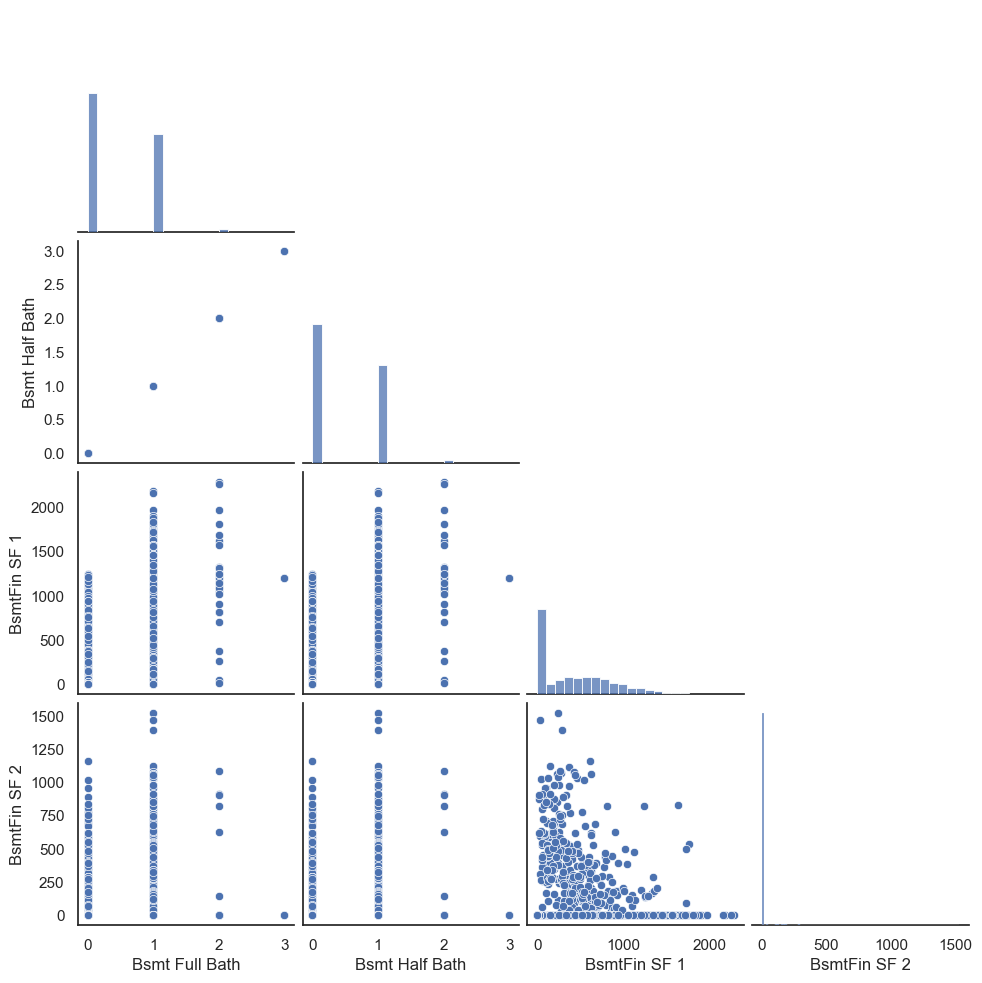

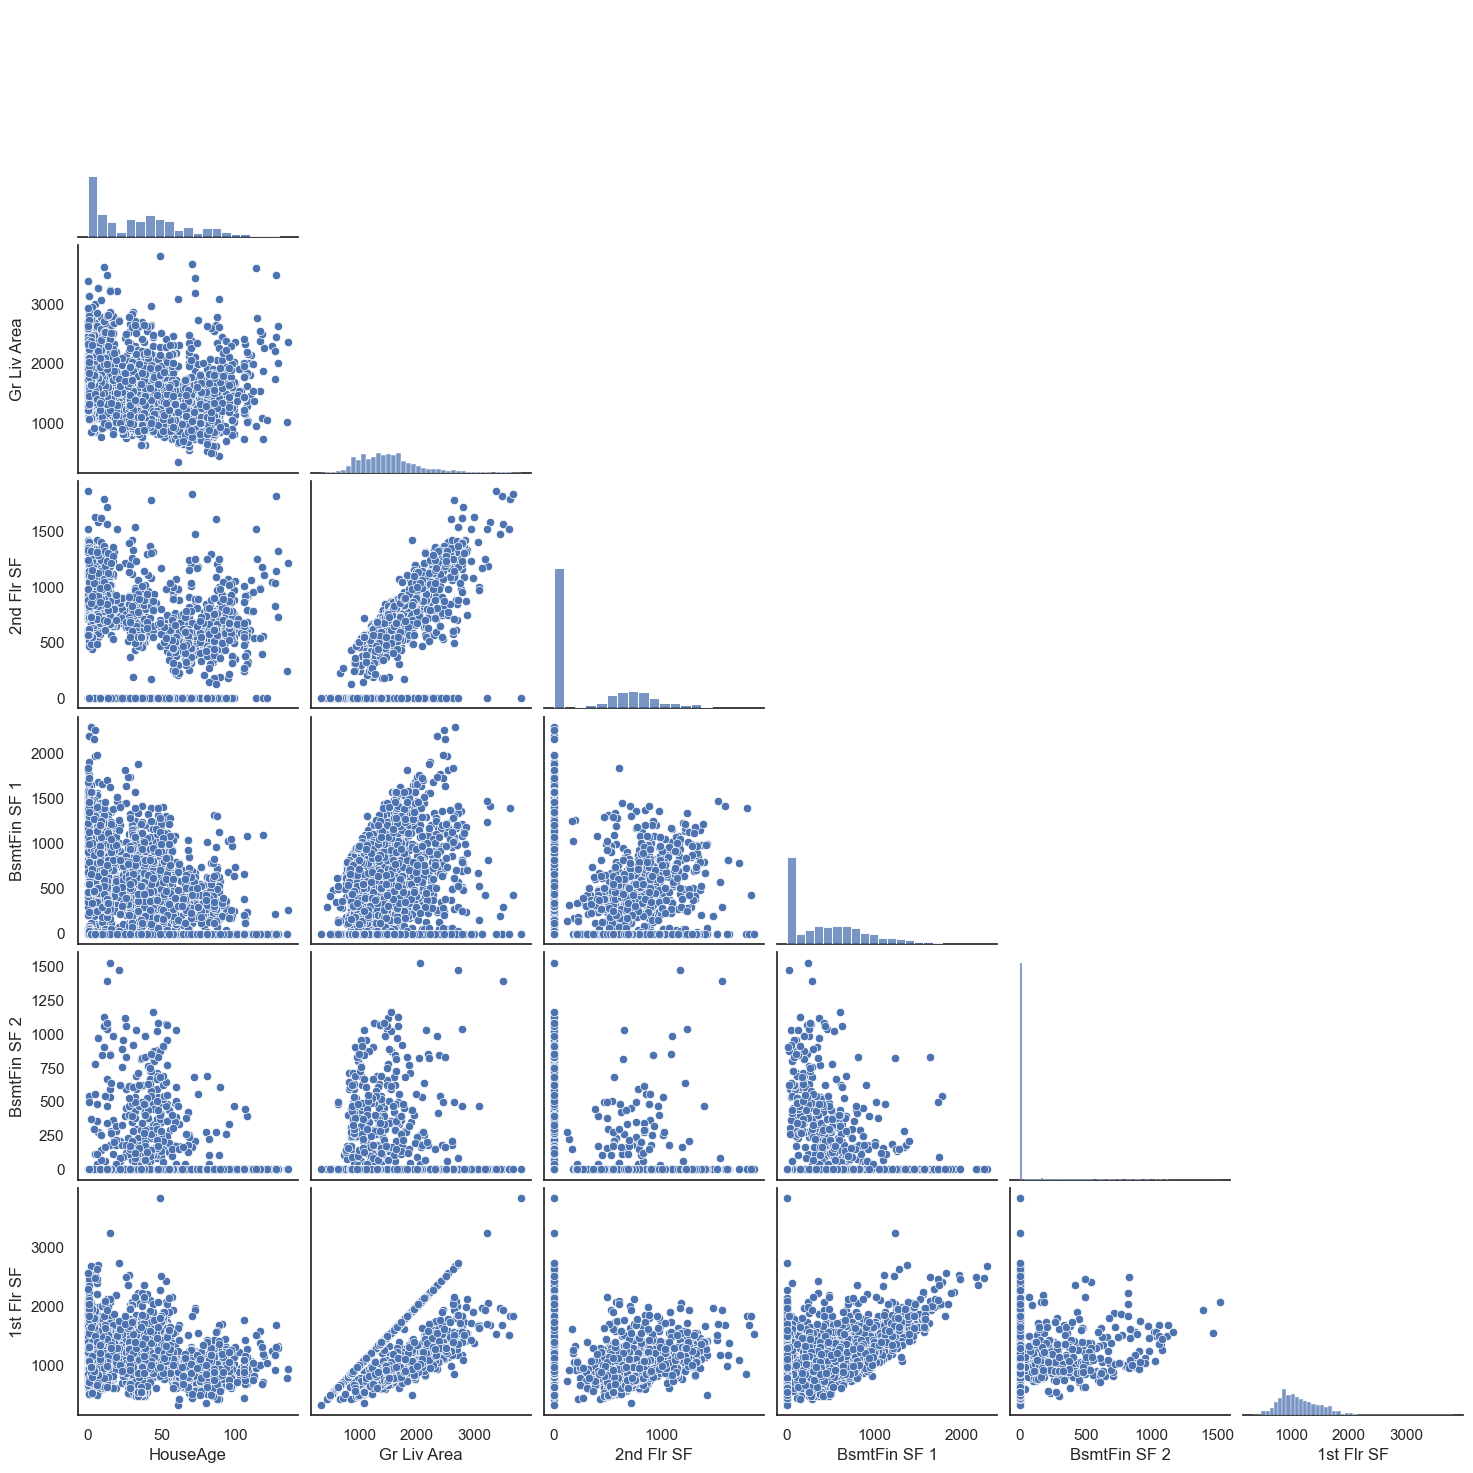

In [14]:
# Multikollinearität
# Welche Spalten sind untereinander start korreliert?

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr(numeric_only = True)
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened


def corrMatrix (dfc, method):
    # method='pearson' oder 'spearman'
    # Korrelationsmatrix der numerischen Variablen

    corr = dfc.corr(method=method)
    # mask and melt correlation matrix
    mask = np.tril(np.ones_like(corr, dtype=bool)) | corr.abs().le(0.1); # trim lower matrix triangle
    melt = corr.mask(mask).melt(ignore_index=False).reset_index();
    melt["size"] = melt["value"].abs();

    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(20, 20));
    # normalize colorbar
    cmap = plt.cm.RdBu;
    norm = plt.Normalize(-1, 1);
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap);
    cbar = plt.colorbar(sm, ax=ax);
    cbar.ax.tick_params(labelsize="x-small");
    # plot lower triangle (scatter plot with normalized hue and square markers)
    sns.scatterplot(ax=ax, data=melt, x="index", y="variable", size="size",
                    hue="value", hue_norm=norm, palette=cmap,
                    style=0, markers=["s"], legend=False);
    # format grid
    xmin, xmax = (-0.5, corr.shape[0] - 0.5);
    ymin, ymax = (-0.5, corr.shape[1] - 0.5);
    _ = ax.vlines(np.arange(xmin, xmax + 1), ymin, ymax, lw=1, color="silver");
    _ = ax.hlines(np.arange(ymin, ymax + 1), xmin, xmax, lw=1, color="silver");
    _ = ax.set(aspect=1, xlim=(xmin, xmax), ylim=(ymax, ymin), xlabel="", ylabel="")
    _ = ax.tick_params(labelbottom=False, labeltop=True);
    _ = plt.xticks(rotation=90);
    # annotate upper triangle
    for y in range(corr.shape[0]):
        for x in range(corr.shape[1]):
            value = corr.mask(mask).to_numpy()[y, x]
            if pd.notna(value):
                _ = plt.text(x, y, f"{value:.2f}", size="x-small",
                         # color=sm.to_rgba(value), weight="bold",
                         ha="center", va="center");
    _ = plt.title("Korrelation nach "+method)            
    _ = plt.show()
    #_ = fig.savefig ('Ames _'+method+'.png')

#df_num.info()
df1 = df_num.select_dtypes('number')
df1.sort_index(axis=1, inplace=True) # Sortieren der Column Name für den Plot
corrMatrix (df1, 'pearson')    # method='pearson' oder 'spearman'
corrFilter(df_num, .6)

features = ['Bsmt Full Bath','Bsmt Half Bath', 'Bsmt Unf SF','BsmtFin SF 1','BsmtFin SF 2']    
splot = sns.pairplot(df_num[features], corner = True)
features = ['HouseAge','Gr Liv Area', '2nd Flr SF','BsmtFin SF 1','BsmtFin SF 2','1st Flr SF']    
splot = sns.pairplot(df_num[features], corner = True)


2


C:\myPrograms\Anaconda3\envs\FHDW\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

Cluster 0
['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'Greens' 'GrnHill' 'IDOTRR' 'Landmrk' 'MeadowV'
 'Mitchel' 'NAmes' 'NPkVill' 'NWAmes' 'OldTown' 'SWISU' 'Sawyer' 'SawyerW'
 'Somerst' 'Timber' 'Veenker']
Cluster 1
['NoRidge' 'NridgHt' 'StoneBr']


<Figure size 640x480 with 0 Axes>

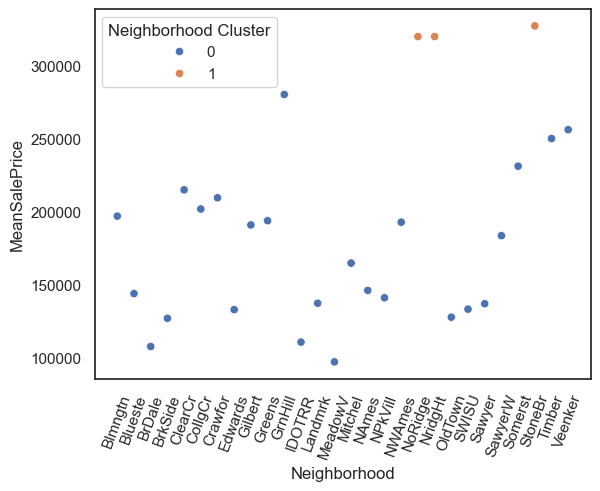

3


C:\myPrograms\Anaconda3\envs\FHDW\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

Cluster 0
['GrnHill' 'NoRidge' 'NridgHt' 'Somerst' 'StoneBr' 'Timber' 'Veenker']
Cluster 1
['Blmngtn' 'ClearCr' 'CollgCr' 'Crawfor' 'Edwards' 'Gilbert' 'Mitchel'
 'NAmes' 'NWAmes' 'OldTown' 'SawyerW']
Cluster 2
['Blueste' 'BrDale' 'BrkSide' 'Greens' 'IDOTRR' 'Landmrk' 'MeadowV'
 'NPkVill' 'SWISU' 'Sawyer']


<Figure size 640x480 with 0 Axes>

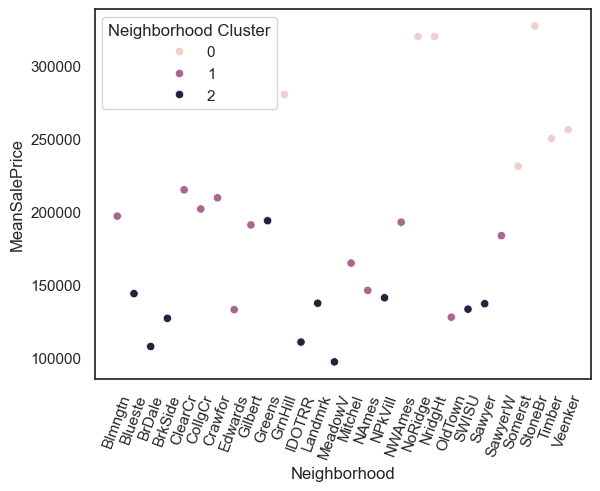

4


C:\myPrograms\Anaconda3\envs\FHDW\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

Cluster 0
['GrnHill' 'Somerst' 'Timber' 'Veenker']
Cluster 1
['Blmngtn' 'ClearCr' 'CollgCr' 'Crawfor' 'Edwards' 'Gilbert' 'Mitchel'
 'NAmes' 'NWAmes' 'OldTown' 'SawyerW']
Cluster 2
['Blueste' 'BrDale' 'BrkSide' 'Greens' 'IDOTRR' 'Landmrk' 'MeadowV'
 'NPkVill' 'SWISU' 'Sawyer']
Cluster 3
['NoRidge' 'NridgHt' 'StoneBr']


<Figure size 640x480 with 0 Axes>

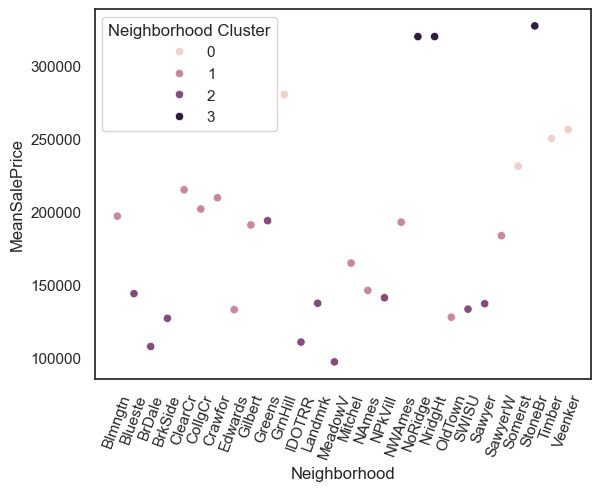

5


C:\myPrograms\Anaconda3\envs\FHDW\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

Cluster 0
['GrnHill']
Cluster 1
['Blmngtn' 'Edwards' 'Gilbert' 'Mitchel' 'NAmes' 'NWAmes' 'OldTown'
 'SawyerW']
Cluster 2
['Blueste' 'BrDale' 'BrkSide' 'Greens' 'IDOTRR' 'Landmrk' 'MeadowV'
 'NPkVill' 'SWISU' 'Sawyer']
Cluster 3
['NoRidge' 'NridgHt' 'StoneBr']
Cluster 4
['ClearCr' 'CollgCr' 'Crawfor' 'Somerst' 'Timber' 'Veenker']


<Figure size 640x480 with 0 Axes>

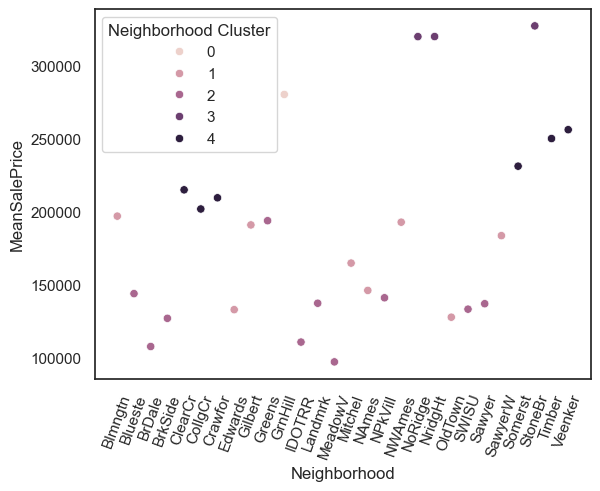

In [15]:
# Cluster Analyse 
# Wieviele Cluster können sinnvoll interpretiert werden?

# https://www.kaggle.com/code/limyenwee/stacked-ensemble-models-top-3-on-leaderboard

N_CLUSTER = 6
RANDOM_STATE = 42

neighborhood = df_num.groupby(['Neighborhood_org'])['SalePrice'].describe()
neighborhood['std'] = neighborhood['std'].fillna(0.0) # Sonderfall wenn ein Vorort nur 1 Haus hat, dann ist Standardabweichung = Nan
#display(neighborhood.head(100))

for i  in range(2,N_CLUSTER):
    print(i)
    neighborhood_cluster = KMeans(n_clusters=i, random_state = RANDOM_STATE)
    neighborhood_cluster.fit(neighborhood)
    neigh_cluster_table = pd.DataFrame(zip(list(neighborhood.index),list(neighborhood.loc[:,'mean']),list(neighborhood_cluster.labels_)),columns = \
                                       ['Neighborhood','MeanSalePrice','Neighborhood Cluster'])
    for i  in range(len(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique())):
        print("Cluster " + str(i))
        print(neigh_cluster_table.groupby('Neighborhood Cluster')['Neighborhood'].unique()[i])
    plt.figure(i)
    _ = sns.scatterplot(data = neigh_cluster_table, x='Neighborhood',y = 'MeanSalePrice', hue='Neighborhood Cluster')
    _ = plt.xticks(rotation=70)
    _ = plt.show()

In [ ]:
# Hilfsanweisung, um eine Liste der Variablen zu bekommen für copy&paste
for col in np.sort(df_num.columns):     print("'" + col +"'," )



In [21]:
# Aufbereitete Daten zur Modellbildung ausgeben


# Block, um Datenmenge gezielt ein zu schränken
#cond1 = (df["Lot Area"] >= 12000)
#cond2 = (df["Lot Area"] <= 14000)
#cond3 = (df["Mas Vnr Area"] >= 100)
#cond4 = (df["Gr Liv Area"] >= 1400)
#cond5 = (df["Gr Liv Area"] <= 2200)
#cond6 = (df["Garage Area"] >= 400)
#cond7 = (df["Overall Qual"] >= 6)
#cond8 = (df["Year Built"] >= 1010)
#cond9 = (df["Year Built"] >= 1010)
#len(np.where(cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9)[0])
#df_num2=df_num.loc[cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7 & cond8 & cond9].sort_values(by=['SalePrice'])

All_Vars_num = df_num.select_dtypes(exclude=['object'])
All_Vars_num.to_csv('Ames_Cleaned_all.csv', index=False)

train_features = df_num[  # handausgesuchte Variablen
['SalePrice',
 'Order',   # OrderNo mitgeben, damit Tooltips im interaktiven Plot nach der Modellerstellung Daten dazu matchen und anzeigen können.
'Bsmt Qual',
'Exter Qual',
'Fireplace Qu',
'Functional',
'Garage Area',
'Garage Qual',
'Gr Liv Area',  # Anzeige Tooltip
'HouseAge',  # Anzeige Tooltip
'TotalPorchSF', 
'Kitchen Qual',
'Land Contour',
'Lot Area',  # Anzeige Tooltip
'Lot Frontage',
'Lot Shape',
'Mas Vnr Area',
'Misc Val',
'NeighborhoodClass',
'Overall Cond',
'Pool QC',
'PosFeature_Adjacent',
'PosFeature_Near',
'Railroad_Adjacent',
'Railroad_Near',
'RemodelAge',  # Anzeige Tooltip
'Total Bsmt SF',
'TotalBathrooms' # Anzeige Tooltip
]]

train_features.to_csv('Ames_Cleaned_26_v1.csv', index=False)